# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы

- Исследовательский анализ данных (изучение информации о таблицах, графический анализ)
- Предобработка данных (удаление аномалий, заполнение пропусков, где возможно)
- агрегация данных в один датафрейм для обучения модели, создание тренировочной и тестовой выборок
- Сравнительный анализ нескольких моделей на тренировочной выборке (LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor)
- Тестирование лучшей модели на тестовой выборке
- Отчет

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from pyod.models.knn import KNN
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from statistics import median

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

### Данные об электродах

In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc.head(20)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

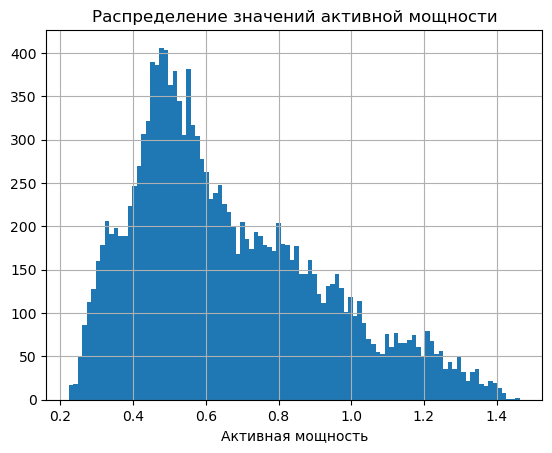

In [6]:
data_arc['Активная мощность'].hist(bins=100)
plt.xlabel('Активная мощность')
plt.title('Распределение значений активной мощности')
data_arc['Активная мощность'].describe()

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

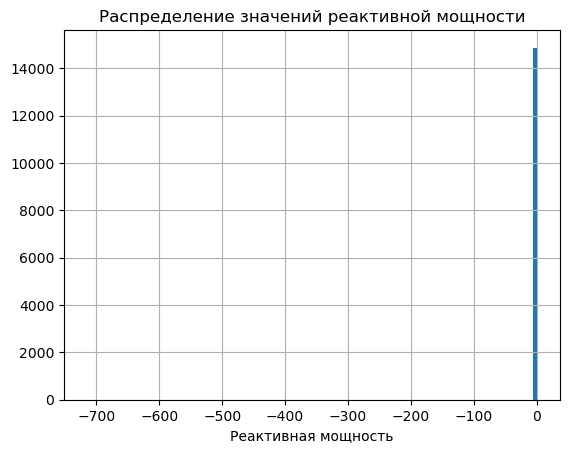

In [7]:
data_arc['Реактивная мощность'].hist(bins=100)
plt.xlabel('Реактивная мощность')
plt.title('Распределение значений реактивной мощности')
data_arc['Реактивная мощность'].describe()

count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: Реактивная мощность, dtype: float64

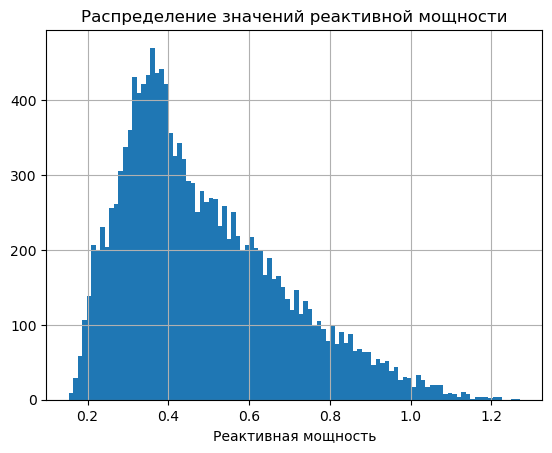

In [8]:
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100)
plt.xlabel('Реактивная мощность')
plt.title('Распределение значений реактивной мощности')
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].describe()

Можно сразу обратить внимание, что в столбце "Реактивная мощность" присутствуют аномальные значения (она не может быть меньше 0), которые придется удалять на этапе предобработки.
В остальном можно сказать, что данные в обоих столбцах распределены нормально с небольшим смещением влево.

### Данные о подаче сыпучих материалов (объем)

In [9]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
data_bulk.head(20)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Bulk 1


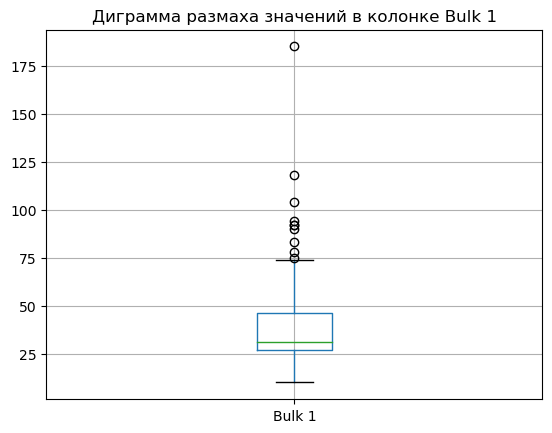

Bulk 2


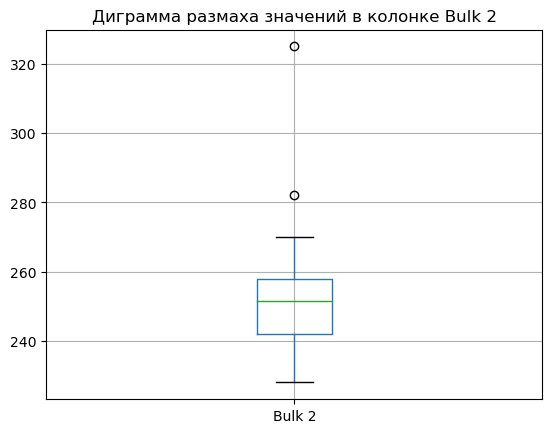

Bulk 3


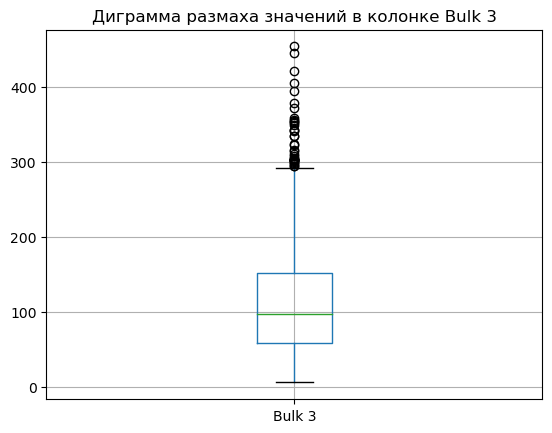

Bulk 4


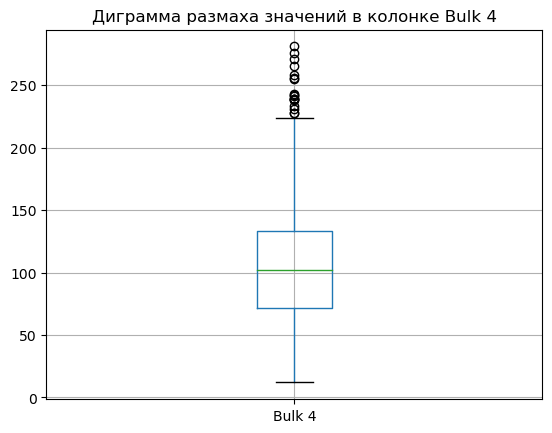

Bulk 5


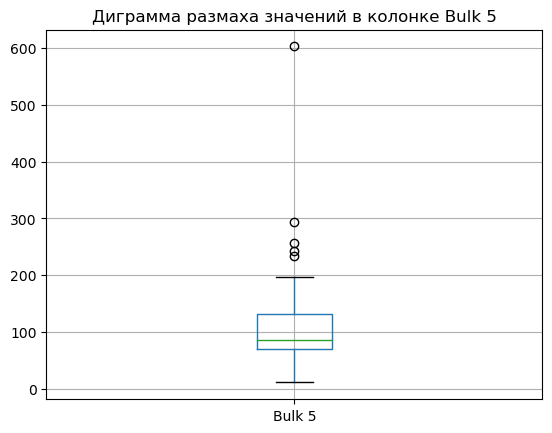

Bulk 6


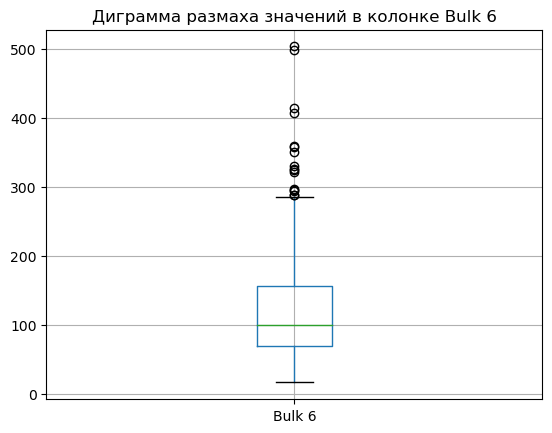

Bulk 7


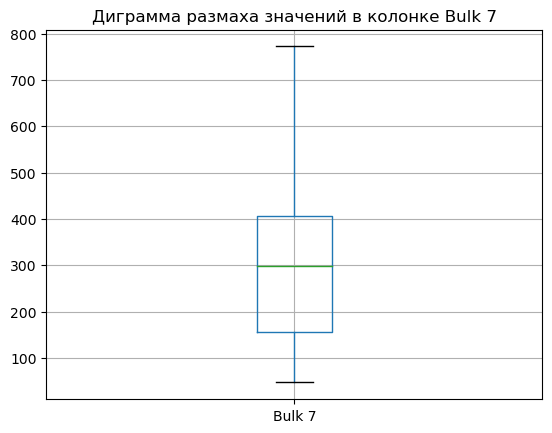

Bulk 8


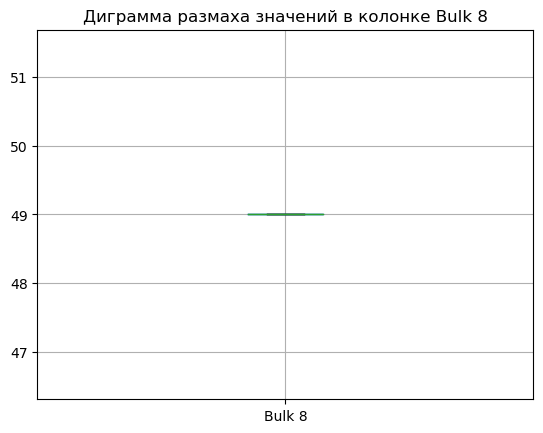

Bulk 9


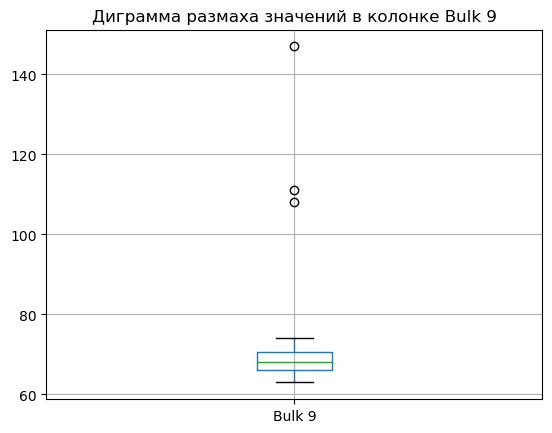

Bulk 10


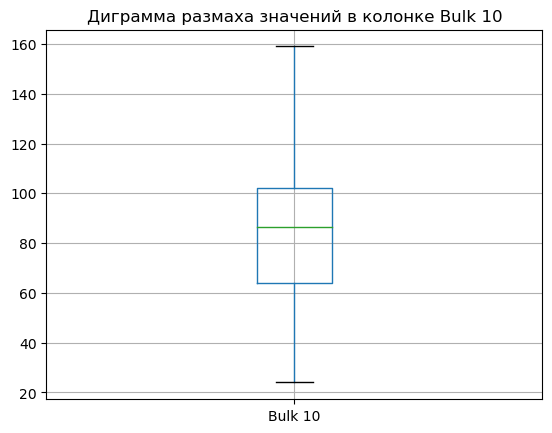

Bulk 11


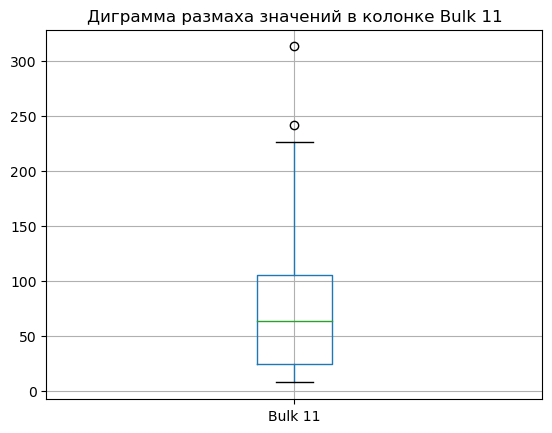

Bulk 12


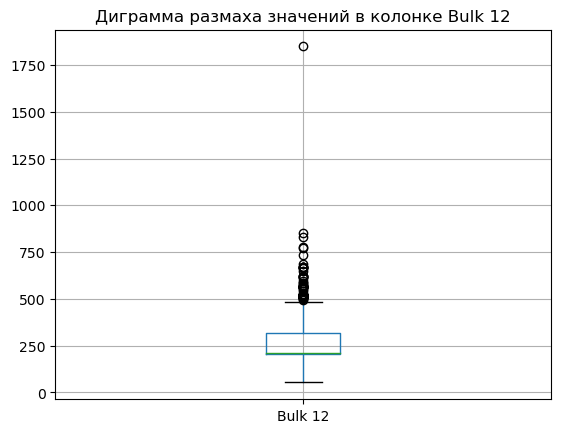

Bulk 13


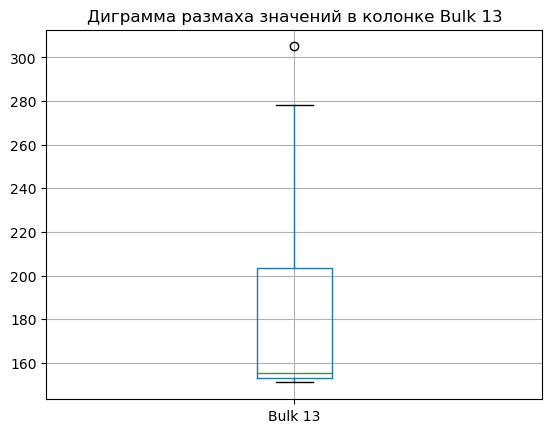

Bulk 14


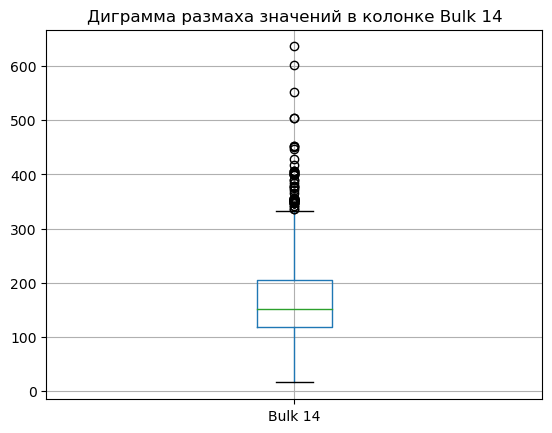

Bulk 15


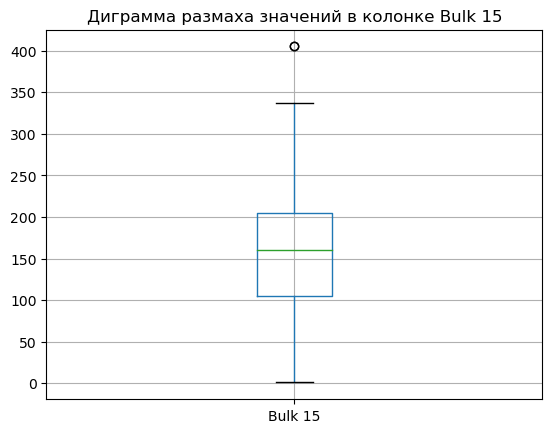

In [11]:
for column in data_bulk.columns:
    if column != 'key':
        print(column)
        data_bulk.boxplot(column=column)
        plt.title('Диграмма размаха значений в колонке '+column)
        plt.show()

Из графиков можно видеть, что во многих колонках есть выбросы.

### Данные о подаче сыпучих материалов (время)

In [12]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [13]:
data_bulk_time.head(20)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Пока не очень понятно, зачем нам понадобятся эти данные, ну и в любом случае какой-то дополнительный анализ времени провести не получается.

### Данные о продувке сплава газом

In [14]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [15]:
data_gas.head(20)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

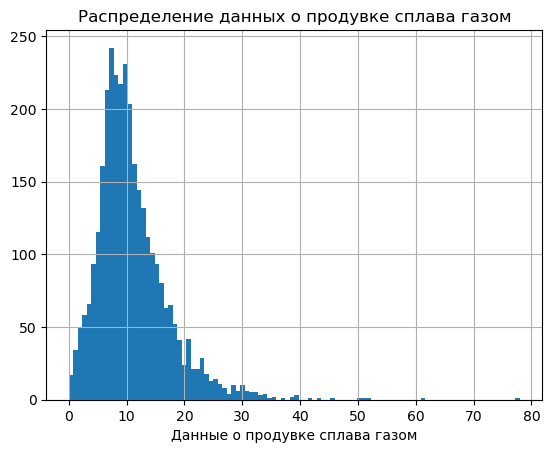

In [16]:
data_gas['Газ 1'].hist(bins=100)
plt.xlabel('Данные о продувке сплава газом')
plt.title('Распределение данных о продувке сплава газом')
data_gas['Газ 1'].describe()

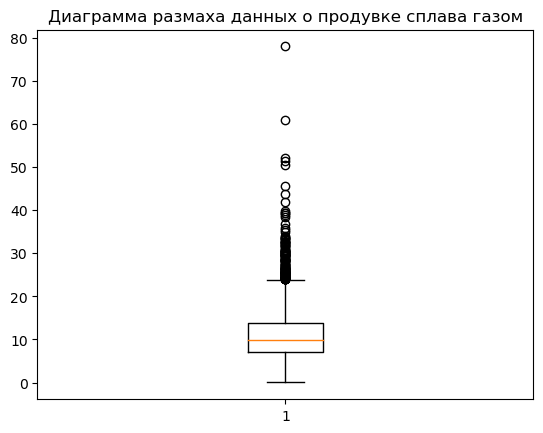

In [17]:
plt.boxplot(data_gas['Газ 1'])
plt.title('Диаграмма размаха данных о продувке сплава газом')
plt.show()

Данные распределены нормально со смещением влево.

### Результаты измерения температуры

In [18]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [19]:
data_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

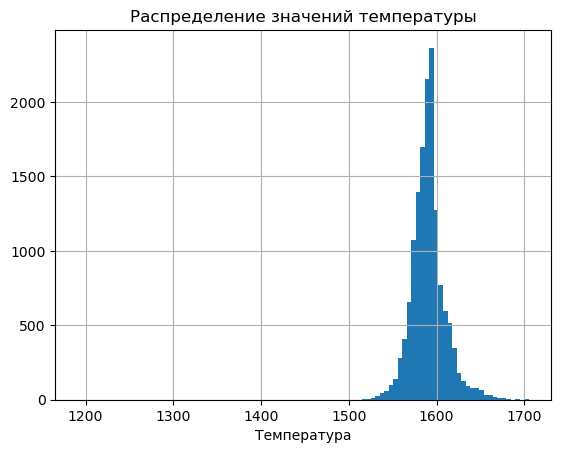

In [20]:
data_temp['Температура'].hist(bins=100)
plt.xlabel('Температура')
plt.title('Распределение значений температуры')
data_temp['Температура'].describe()

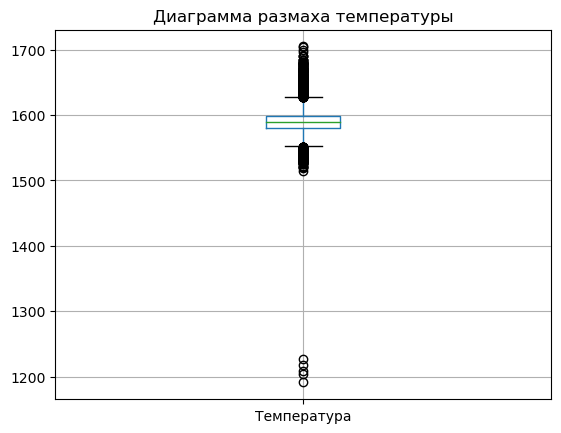

In [21]:
data_temp.boxplot(column='Температура')
plt.title('Диаграмма размаха температуры')
plt.show()

Данные распределены нормально.
По диаграмме размаха можно видеть, что явно выделяются показатели в районе 1200, это температура ниже температуры плавления стали. Значит, это ошибки в данных, которые потом придется удалять.

### Данные о проволочных материалах (объём)

In [22]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [23]:
data_wire.head(20)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wire 1


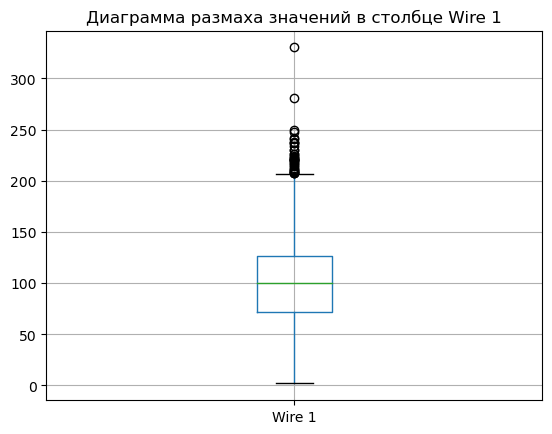

Wire 2


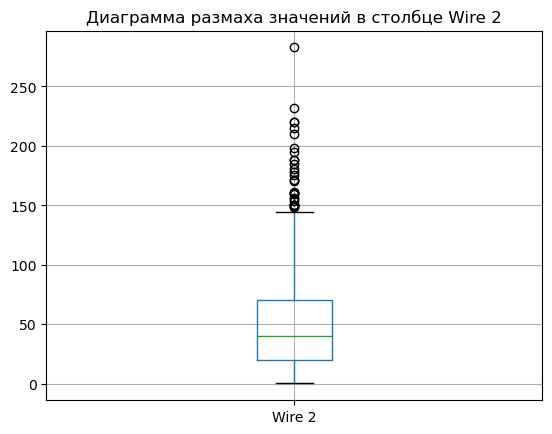

Wire 3


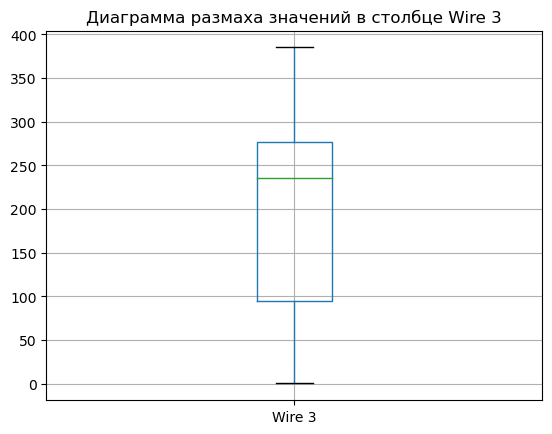

Wire 4


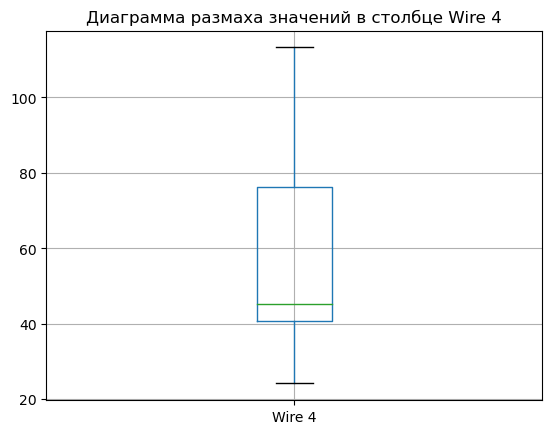

Wire 5


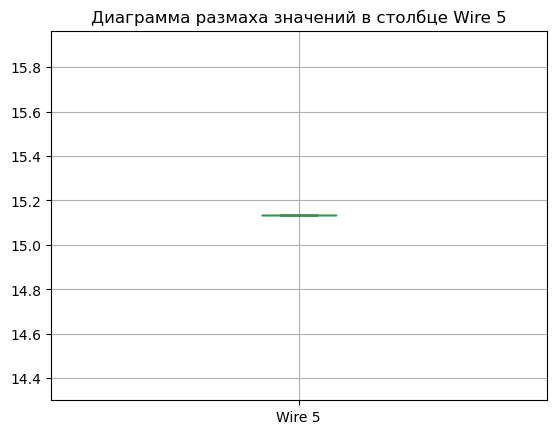

Wire 6


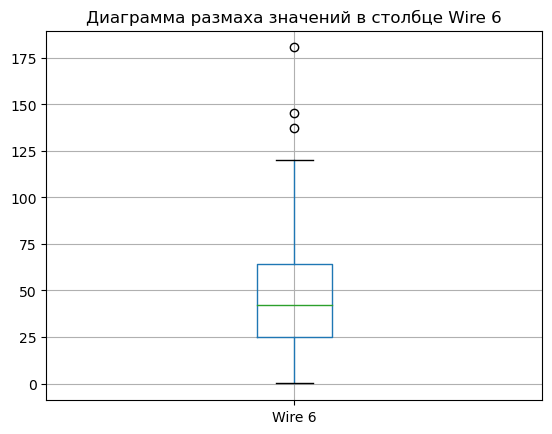

Wire 7


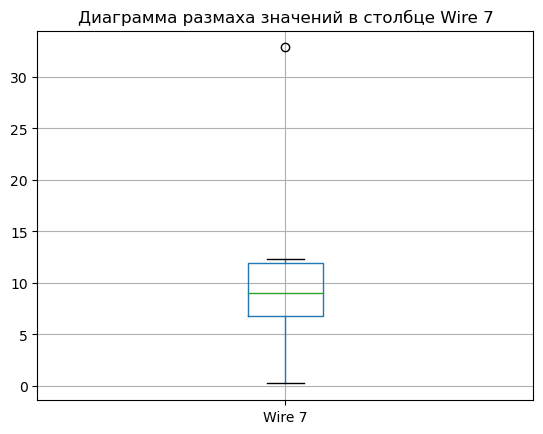

Wire 8


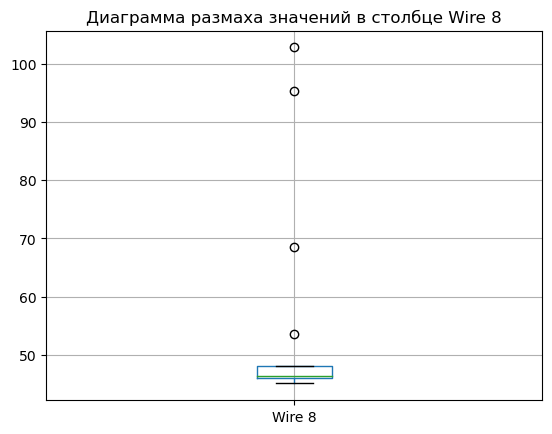

Wire 9


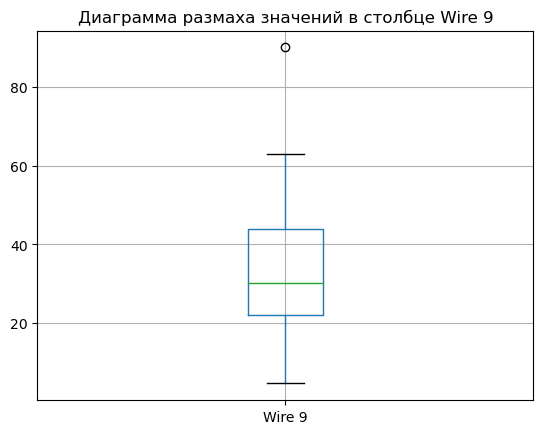

In [24]:
for column in data_wire.columns:
    if column != 'key':
        print(column)
        data_wire.boxplot(column=column)
        plt.title('Диаграмма размаха значений в столбце '+column)
        plt.show()

В этой таблице можно увидеть разные распределения данных в 9 колонках.

В некоторых колонках есть хорошо заметные на графиках выбросы.

### Данные о проволочных материалах (время)

In [25]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [26]:
data_wire_time.head(20)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь, как и в случае с данными о времени подачи сыпучих материалов, мы не можем сказать ничего конкретного про эти данные.

### Вопросы к заказчику

- в каком формате требуются результаты?
- какая ошибка в температуре приемлема? абсолютно точного предсказания быть не может, поэтому вопрос: в какой интервал точно должен попадать ответ?

### Выводы по части 1

Суммируя то, что мы выяснили на этапе исследовательского анализа данных, можно сказать следующее:
- данные почти везде распределены нормально
- есть очевидно аномальные значения, которые нужно будет удалять
Помимо того, что уже было написано в комментариях к каждой таблице, можно еще заметить, что:
- дата везде хранится как строка, ее нужно будет перевести в datetime
- названия столбцов нужно привести к единому формату - латиницей и снейккейсом

## Предобработка данных

### Данные об электродах

- переименуем столбцы
- уберем выбросы, где мощность меньше 0 (это встречалось только в колонке с реактивной мощностью)
- создадим столбцы с суммарной активной и реактивной мощностью по ключу
- добавим новый признак - общая мощность (посчитаем по теореме Пифагора)

In [27]:
data_arc.columns = ['key', 'start','end', 'active_power', 'reactive_power']

In [28]:
data_arc_bad = data_arc.query('reactive_power < 0')

In [29]:
keys_delete = list(data_arc_bad['key'])
data_arc = data_arc.query('key not in @keys_delete')

In [30]:
data_arc['start'] = pd.to_datetime(data_arc['start'])
data_arc['end'] = pd.to_datetime(data_arc['end'])

In [31]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14872 non-null  int64         
 1   start           14872 non-null  datetime64[ns]
 2   end             14872 non-null  datetime64[ns]
 3   active_power    14872 non-null  float64       
 4   reactive_power  14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


In [32]:
data_arc.head()

,key,start,end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [33]:
data_arc['work_time'] = data_arc['end'] - data_arc['start']
data_arc.head()

,key,start,end,active_power,reactive_power,work_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28


In [34]:
data_arc['active_energy'] = data_arc['active_power'] * (data_arc['end'] - data_arc['start'])
data_arc['active_energy'] = pd.to_numeric(data_arc['active_energy'])
data_arc['reactive_energy'] = data_arc['reactive_power'] * (data_arc['end'] - data_arc['start'])
data_arc['reactive_energy'] = pd.to_numeric(data_arc['reactive_energy'])

In [35]:
data_arc.head()

,key,start,end,active_power,reactive_power,work_time,active_energy,reactive_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48,69569640000,48165684000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05,141646730000,88326030000
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52,99813836000,74039120000
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05,189251039999,138692335000
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28,128335684000,95266268000


In [36]:
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_energy','reactive_energy'],
                             index='key',
                             aggfunc={'active_energy': np.sum,
                                      'reactive_energy': np.sum})
data_arc_sum.columns = ['active_energy_sum', 'reactive_energy_sum']

In [37]:
data_arc_sum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   active_energy_sum    3213 non-null   int64
 1   reactive_energy_sum  3213 non-null   int64
dtypes: int64(2)
memory usage: 75.3 KB


In [38]:
data_arc_sum.head()

,active_energy_sum,reactive_energy_sum
key,,
1,628616929999,444489437000
2,395281800000,274689995000
3,581774624000,428038924000
4,543710274000,413941976999
5,412180480000,303070918000


### Данные о подаче сыпучих материалов

Для этой таблицы мы пока ограничимся переименованием колонок и установкой key в качестве индекса.

In [39]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]

In [40]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bulk_1   252 non-null    float64
 1   bulk_2   22 non-null     float64
 2   bulk_3   1298 non-null   float64
 3   bulk_4   1014 non-null   float64
 4   bulk_5   77 non-null     float64
 5   bulk_6   576 non-null    float64
 6   bulk_7   25 non-null     float64
 7   bulk_8   1 non-null      float64
 8   bulk_9   19 non-null     float64
 9   bulk_10  176 non-null    float64
 10  bulk_11  177 non-null    float64
 11  bulk_12  2450 non-null   float64
 12  bulk_13  18 non-null     float64
 13  bulk_14  2806 non-null   float64
 14  bulk_15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


In [41]:
data_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


### Данные о продувке сплава газом

С этой таблицей мы сейчас поступим аналогично таблице с сыпучими материалами.

In [42]:
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']

In [43]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gas     3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


In [44]:
data_gas.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


### Результаты измерения температуры

В этой таблице мы:
- удалим из таблицы ключи, для которых был выполнен только один замер температуры или отсутствует финальный замер (температуру замеряли до того, как закончился нагрев дугой)
- удалим пропуски
- удалим выбросы, где температура оказалась меньше 1450 (температура плавления стали)
- сделаем срез по первому и финальному замеру

In [45]:
data_temp.columns = ['key', 'time','temp']

In [46]:
data_temp['time'] = pd.to_datetime(data_temp['time'])

In [47]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     18092 non-null  int64         
 1   time    18092 non-null  datetime64[ns]
 2   temp    14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [48]:
data_temp.head()

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [49]:
data_temp_bad = data_temp.query('temp < 1450')
keys_delete = list(data_temp_bad['key'])
data_temp = data_temp.query('key not in @keys_delete')

In [50]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18065 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     18065 non-null  int64         
 1   time    18065 non-null  datetime64[ns]
 2   temp    14643 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 564.5 KB


In [51]:
keys_delete = []
keys_error = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['time'].max() == 
            data_temp[data_temp['key'] == key]['time'].min())
            or (data_temp[data_temp['key'] == key]['time'].max() < 
            data_arc[data_arc['key'] == key]['end'].max())):
            keys_delete.append(key)
    except:
        keys_error.append(key)
print(keys_delete, len(keys_delete))
print(keys_error, len(keys_error))

[195, 279] 2
[] 0


In [52]:
data_temp = data_temp.query('key not in @keys_delete')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18063 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     18063 non-null  int64         
 1   time    18063 non-null  datetime64[ns]
 2   temp    14641 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 564.5 KB


In [53]:
data_temp_bad = data_temp[data_temp.isnull().any(1)]
keys_delete = list(data_temp_bad['key'])
data_temp = data_temp.query('key not in @keys_delete')

In [54]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     13903 non-null  int64         
 1   time    13903 non-null  datetime64[ns]
 2   temp    13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


In [55]:
data_temp_time = pd.pivot_table(data_temp,
                                values='time',
                                index='key',
                                aggfunc={'time': [np.min, np.max]})

In [56]:
data_temp_time.head()

,amax,amin
key,,
1,2019-05-03 11:30:38,2019-05-03 11:02:04
2,2019-05-03 11:55:09,2019-05-03 11:34:04
3,2019-05-03 12:35:57,2019-05-03 12:06:44
4,2019-05-03 12:59:47,2019-05-03 12:39:27
5,2019-05-03 13:36:39,2019-05-03 13:11:03


In [57]:
start_list = list(data_temp_time['amin'])
end_list = list(data_temp_time['amax'])
data_temp_start = data_temp.query('time in @start_list ')
data_temp_start = data_temp_start.set_index('key')
data_temp_end = data_temp.query('time in @end_list ')
data_temp_end = data_temp_end.set_index('key')
data_temp_final = data_temp_start.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end['temp']
data_temp_final = data_temp_final.drop('time', axis=1)

In [58]:
data_temp_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_temp  2471 non-null   float64
 1   end_temp    2471 non-null   float64
dtypes: float64(2)
memory usage: 57.9 KB


In [59]:
data_temp_final.head()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


### Данные о проволочных материалах

Здесь тоже просто поменяем названия колонок и установим ключи в качестве индексов.

In [60]:
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

In [61]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3055 non-null   float64
 1   wire_2  1079 non-null   float64
 2   wire_3  63 non-null     float64
 3   wire_4  14 non-null     float64
 4   wire_5  1 non-null      float64
 5   wire_6  73 non-null     float64
 6   wire_7  11 non-null     float64
 7   wire_8  19 non-null     float64
 8   wire_9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB


In [62]:
data_wire.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Создание общего датафрейма

In [63]:
data_full = data_arc_sum.copy()
data_full = data_full.merge(data_bulk, how='inner', on='key')
data_full = data_full.merge(data_gas, how='inner', on='key')
data_full = data_full.merge(data_temp_final, how='inner', on='key')
data_full = data_full.merge(data_wire, how='inner', on='key')
data_full = data_full.dropna(subset=['end_temp']) 

Поскольку end_temp - наш целевой признак, мы удаляем все строки, где он не заполнен.

In [64]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   active_energy_sum    2324 non-null   int64  
 1   reactive_energy_sum  2324 non-null   int64  
 2   bulk_1               199 non-null    float64
 3   bulk_2               13 non-null     float64
 4   bulk_3               958 non-null    float64
 5   bulk_4               811 non-null    float64
 6   bulk_5               53 non-null     float64
 7   bulk_6               437 non-null    float64
 8   bulk_7               13 non-null     float64
 9   bulk_8               1 non-null      float64
 10  bulk_9               13 non-null     float64
 11  bulk_10              143 non-null    float64
 12  bulk_11              130 non-null    float64
 13  bulk_12              1809 non-null   float64
 14  bulk_13              14 non-null     float64
 15  bulk_14              2064 non-null   f

In [65]:
data_full.head()

,active_energy_sum,reactive_energy_sum,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,...,end_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,628616929999,444489437000,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,1613.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,395281800000,274689995000,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,...,1602.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,581774624000,428038924000,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,...,1599.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,543710274000,413941976999,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,...,1625.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,412180480000,303070918000,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,...,1602.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропуски можно заполнить нулями.

In [66]:
data_full = data_full.fillna(0)

### Анализ итогового датафрейма

In [67]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   active_energy_sum    2324 non-null   int64  
 1   reactive_energy_sum  2324 non-null   int64  
 2   bulk_1               2324 non-null   float64
 3   bulk_2               2324 non-null   float64
 4   bulk_3               2324 non-null   float64
 5   bulk_4               2324 non-null   float64
 6   bulk_5               2324 non-null   float64
 7   bulk_6               2324 non-null   float64
 8   bulk_7               2324 non-null   float64
 9   bulk_8               2324 non-null   float64
 10  bulk_9               2324 non-null   float64
 11  bulk_10              2324 non-null   float64
 12  bulk_11              2324 non-null   float64
 13  bulk_12              2324 non-null   float64
 14  bulk_13              2324 non-null   float64
 15  bulk_14              2324 non-null   f

In [68]:
data_full.head(20)

,active_energy_sum,reactive_energy_sum,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,...,end_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,628616929999,444489437000,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,1613.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,395281800000,274689995000,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,1602.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,581774624000,428038924000,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,1599.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,543710274000,413941976999,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,1625.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,412180480000,303070918000,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,1602.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,691669688000,474683337999,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,1596.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,491550466999,366161045999,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,1599.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,496597267999,368803429000,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,...,1598.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,464455338000,330257804000,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,1592.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0


active_energy_sum


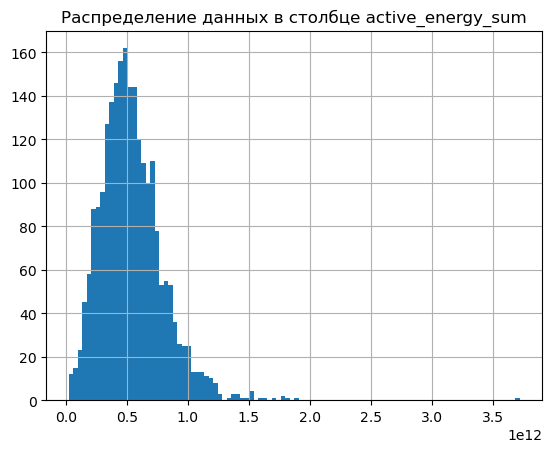

reactive_energy_sum


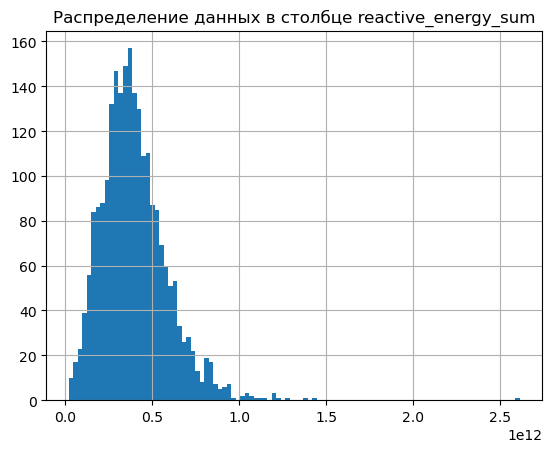

bulk_1


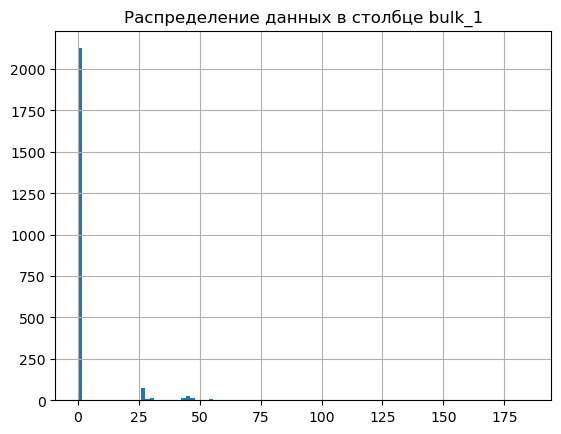

bulk_2


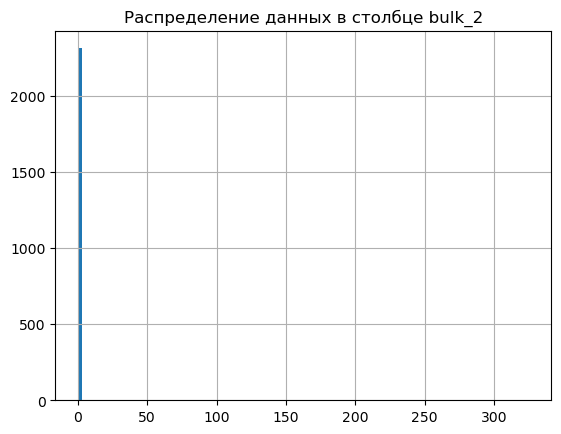

bulk_3


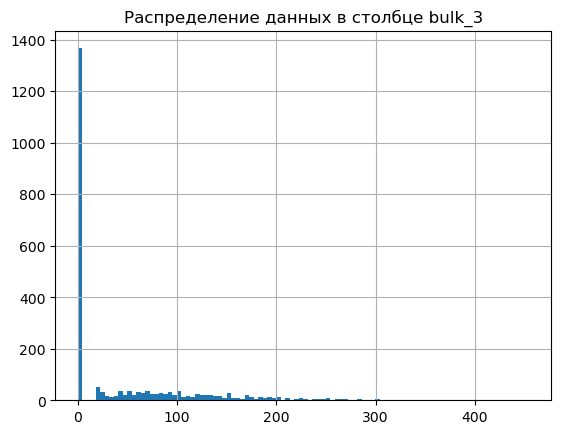

bulk_4


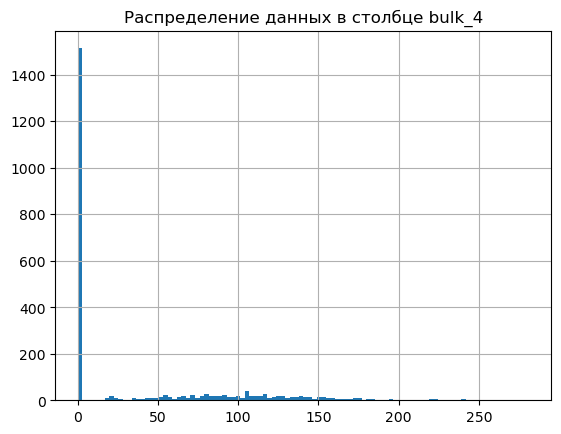

bulk_5


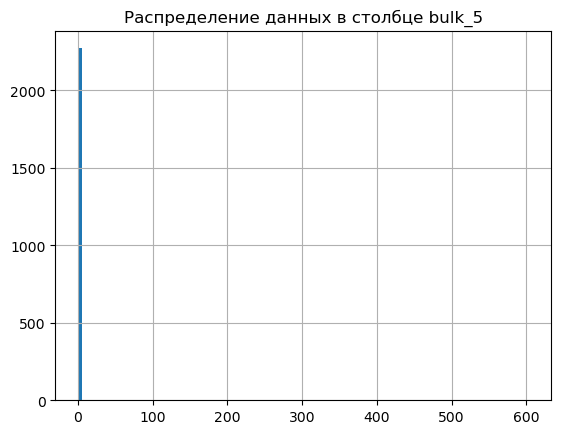

bulk_6


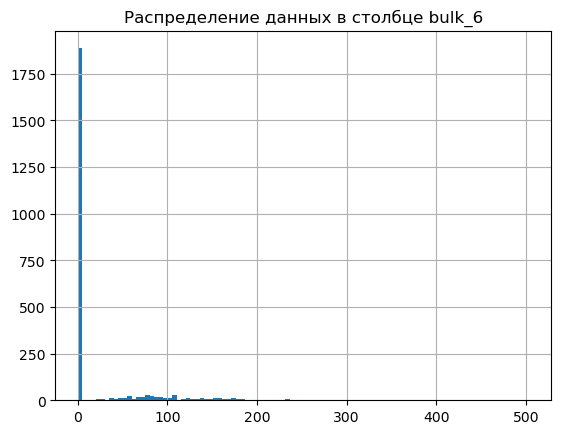

bulk_7


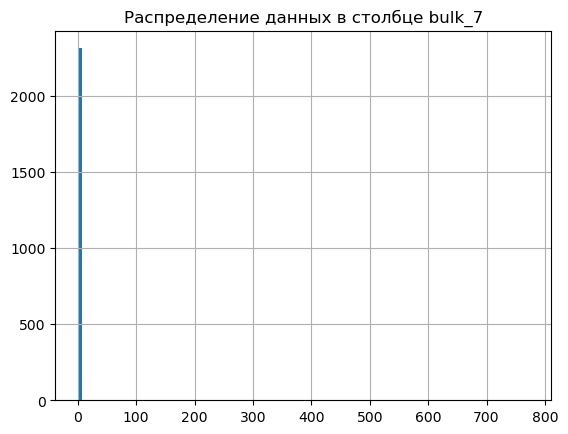

bulk_8


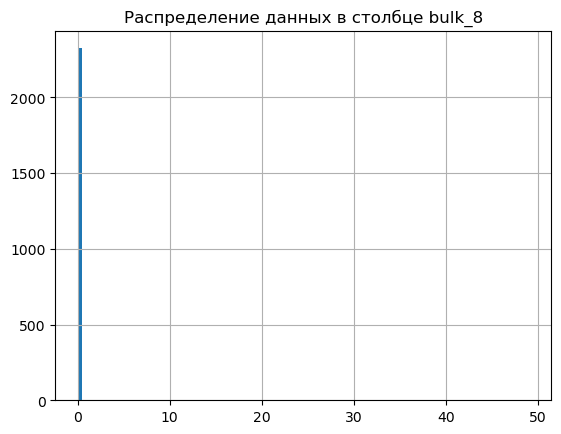

bulk_9


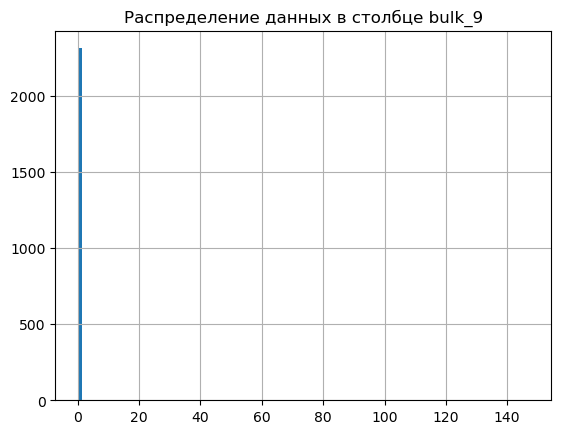

bulk_10


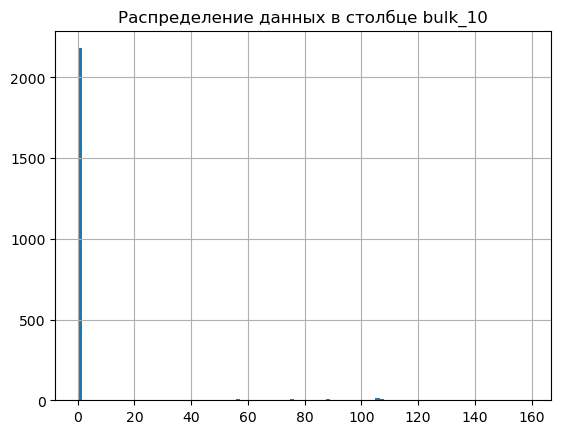

bulk_11


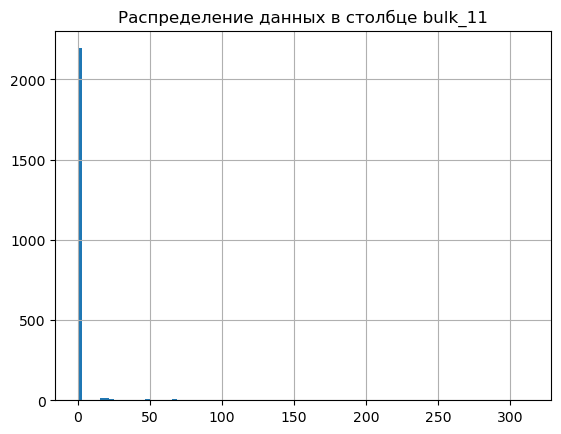

bulk_12


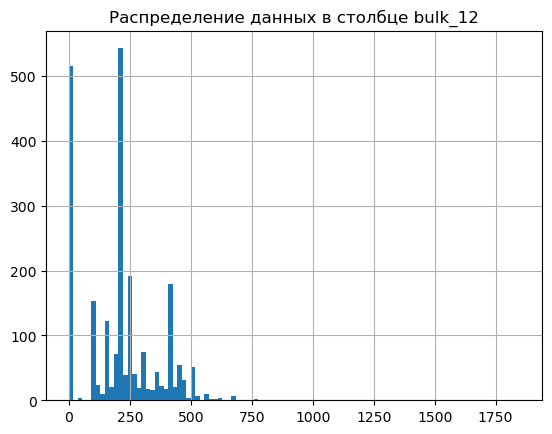

bulk_13


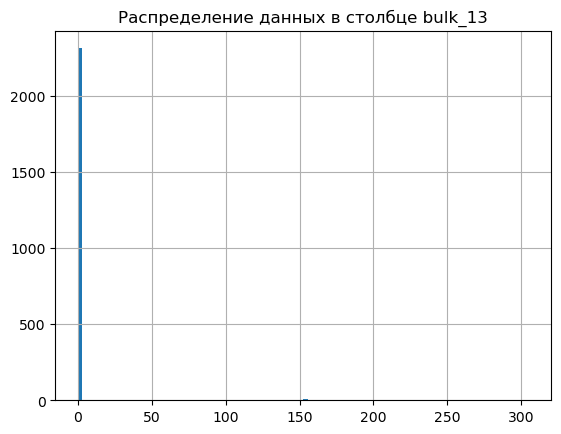

bulk_14


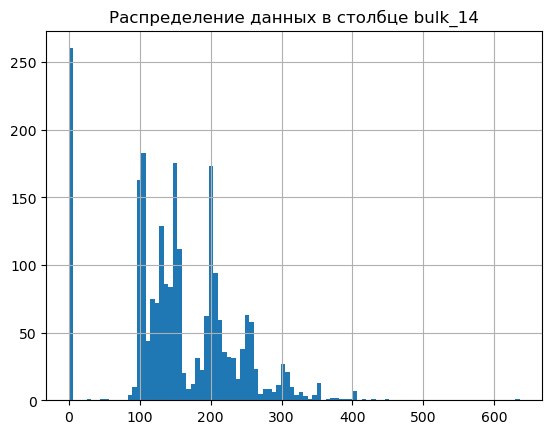

bulk_15


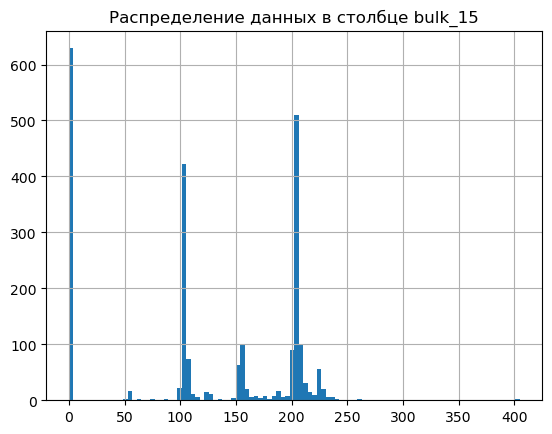

gas


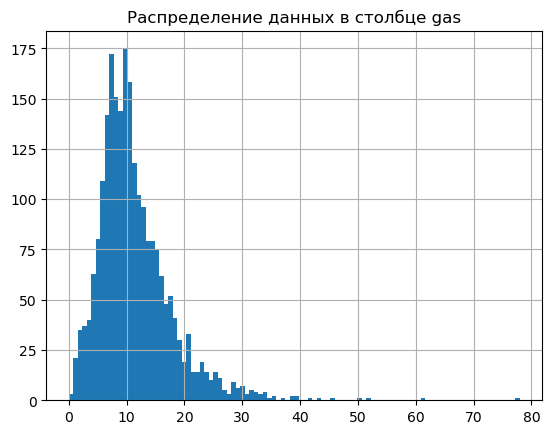

start_temp


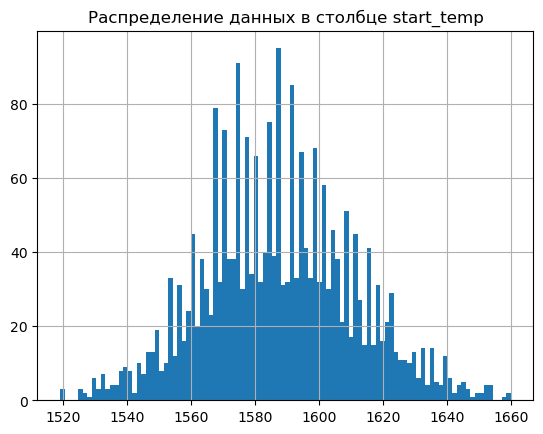

end_temp


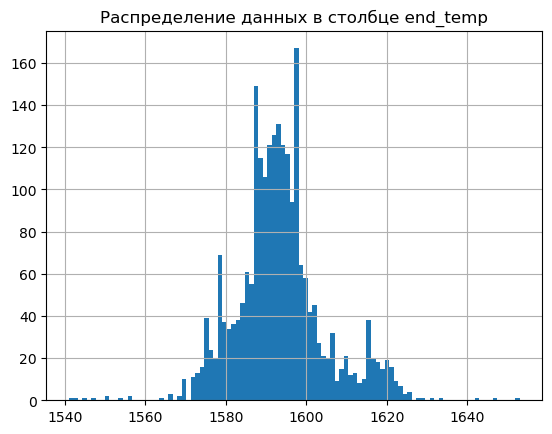

wire_1


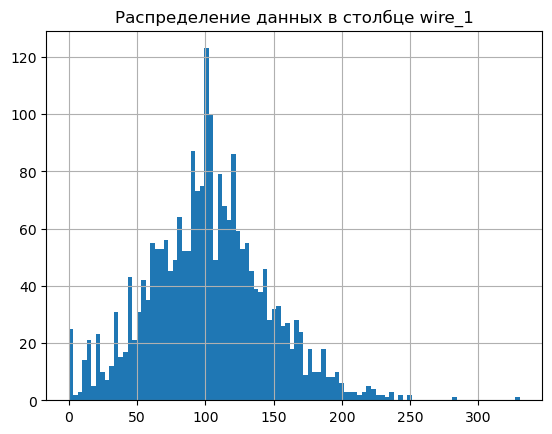

wire_2


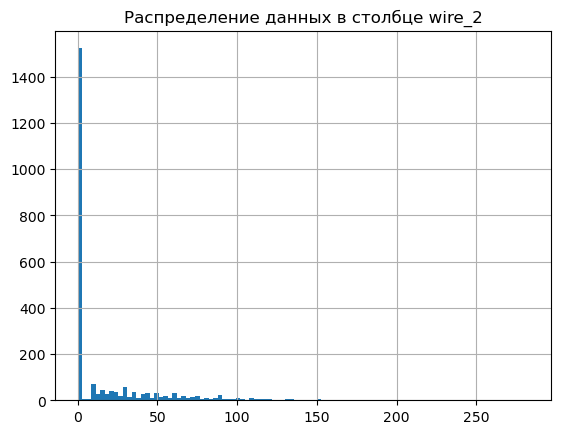

wire_3


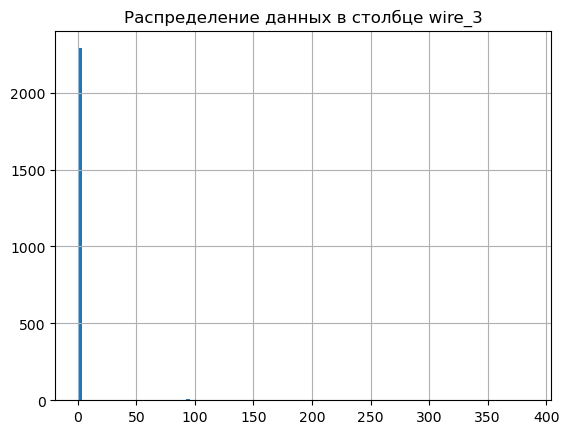

wire_4


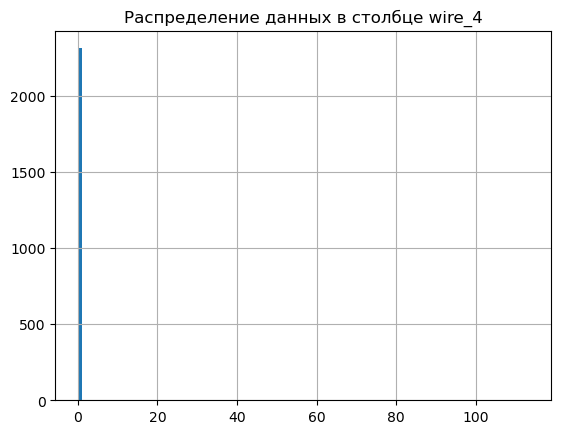

wire_5


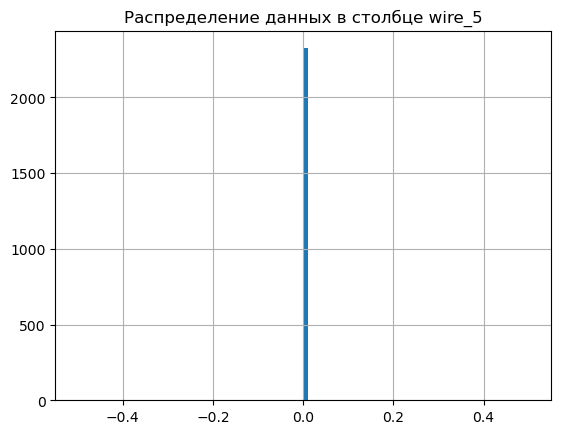

wire_6


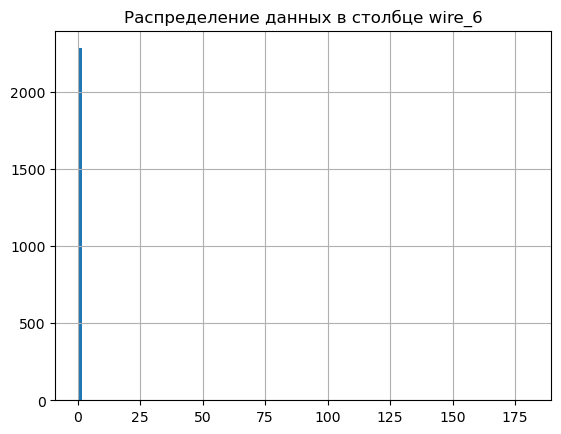

wire_7


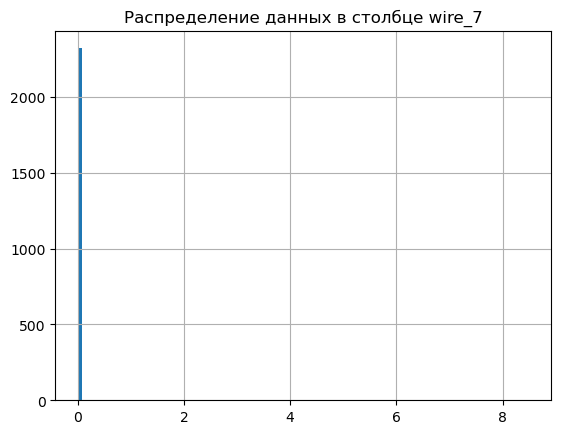

wire_8


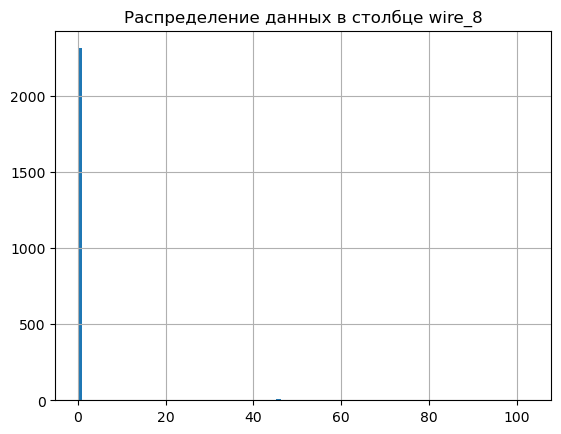

wire_9


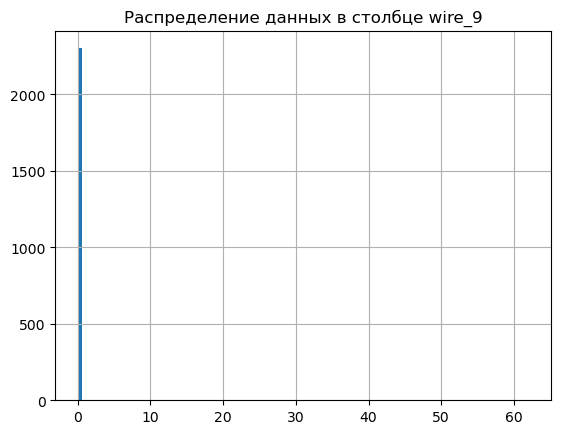

In [69]:
for column in data_full.columns:
    print(column)
    data_full[column].hist(bins=100)
    plt.title('Распределение данных в столбце '+column)
    plt.show()

active_energy_sum


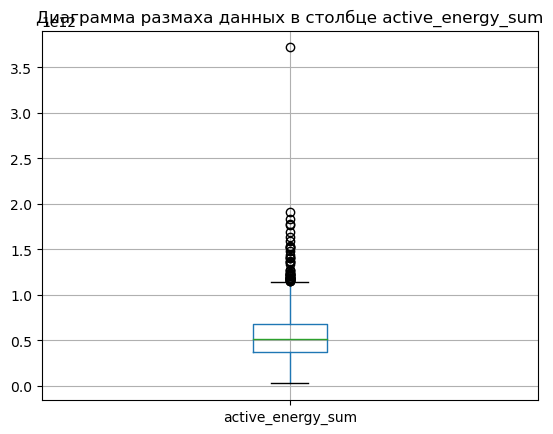

reactive_energy_sum


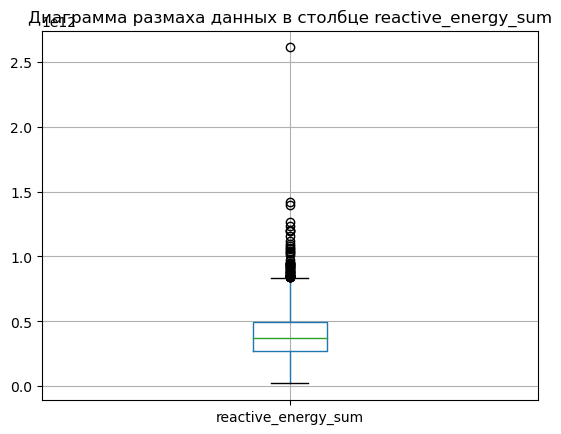

bulk_1


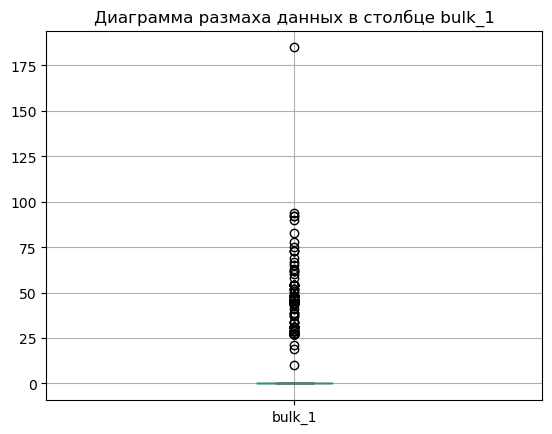

bulk_2


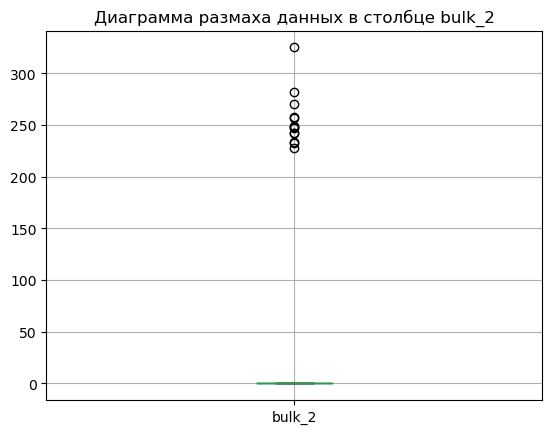

bulk_3


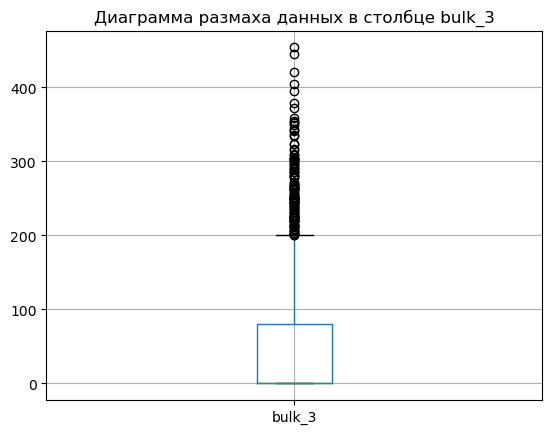

bulk_4


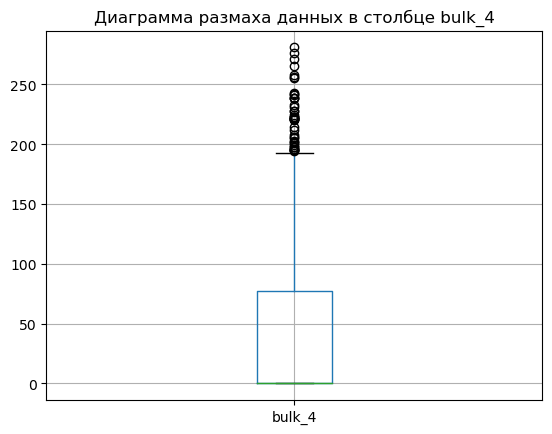

bulk_5


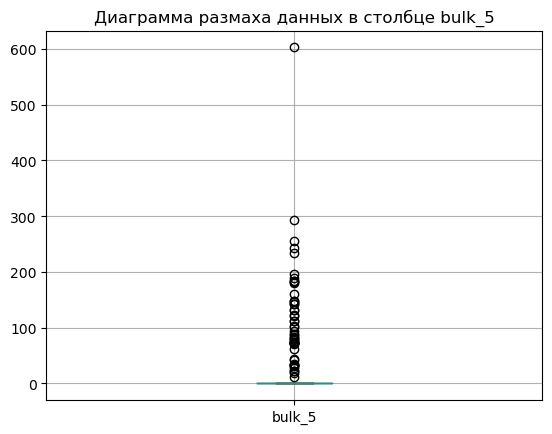

bulk_6


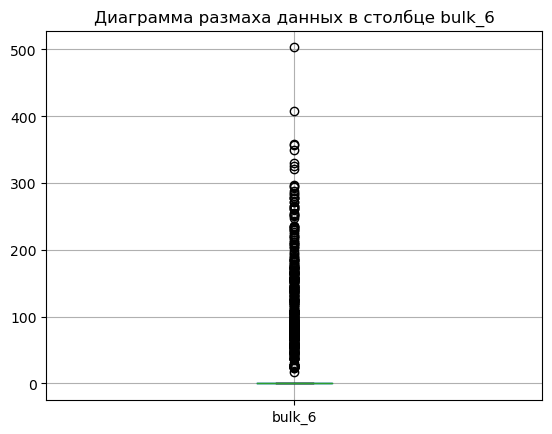

bulk_7


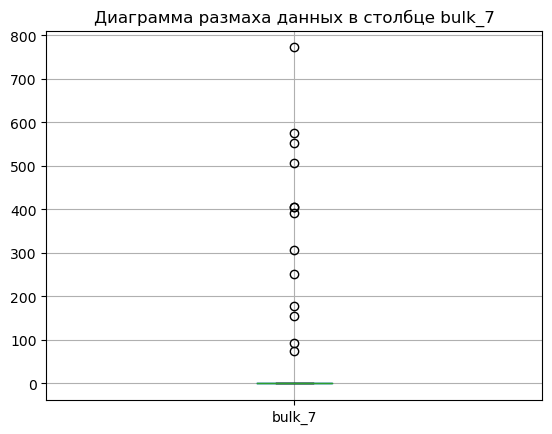

bulk_8


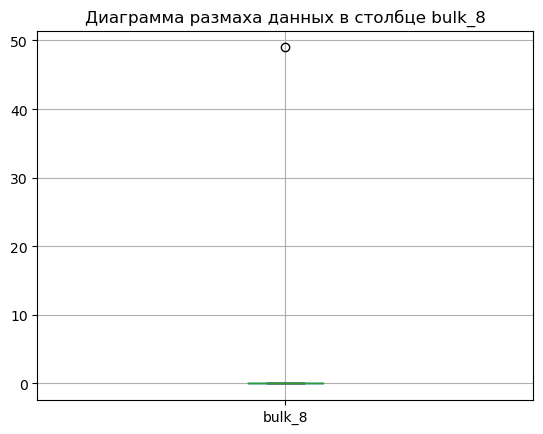

bulk_9


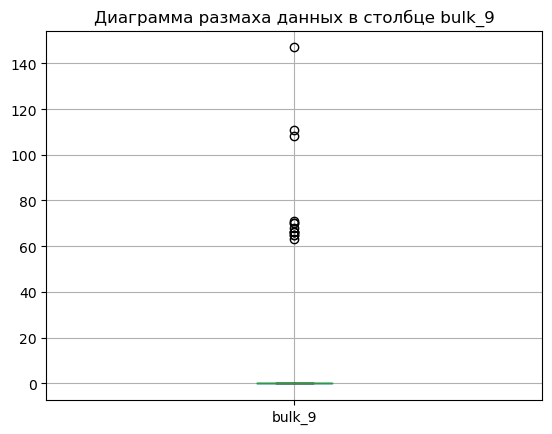

bulk_10


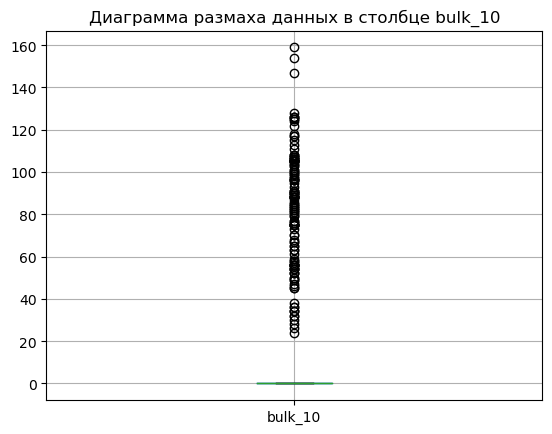

bulk_11


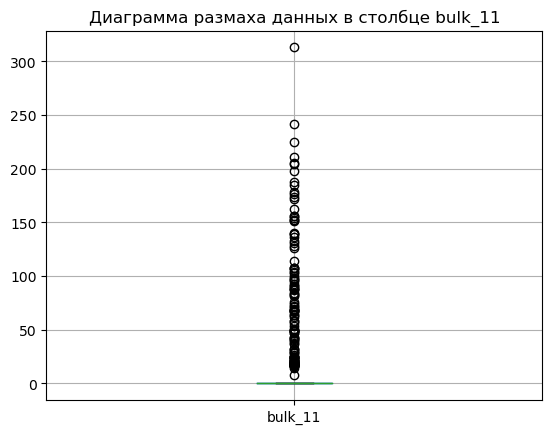

bulk_12


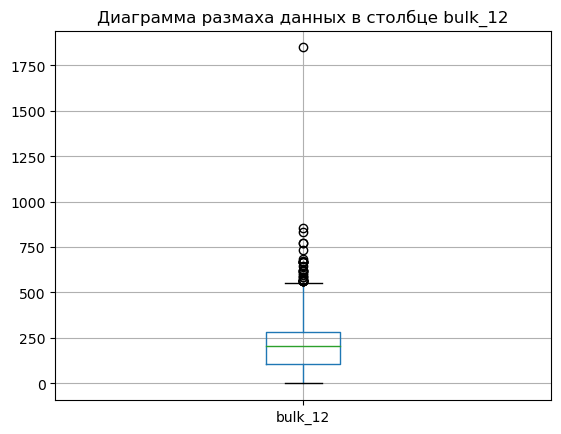

bulk_13


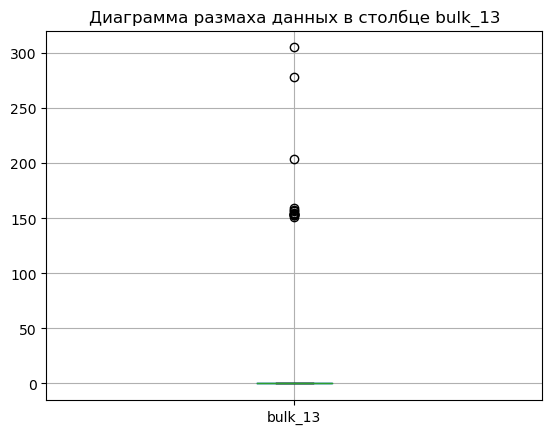

bulk_14


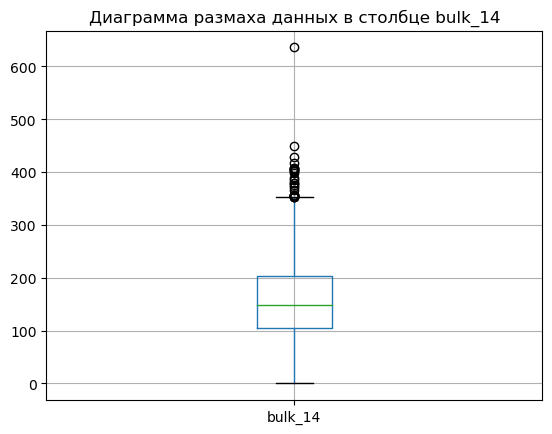

bulk_15


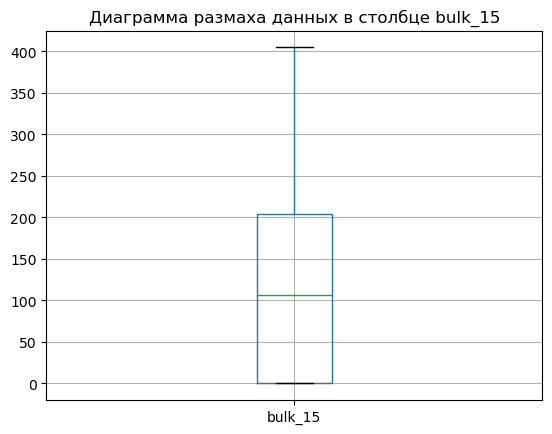

gas


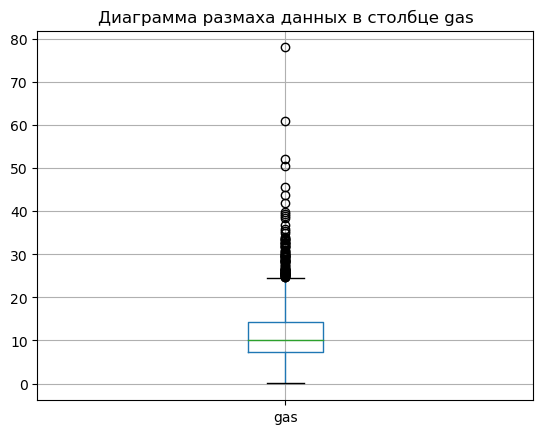

start_temp


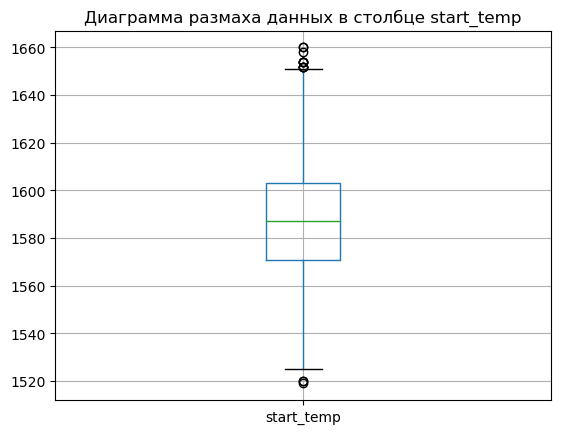

end_temp


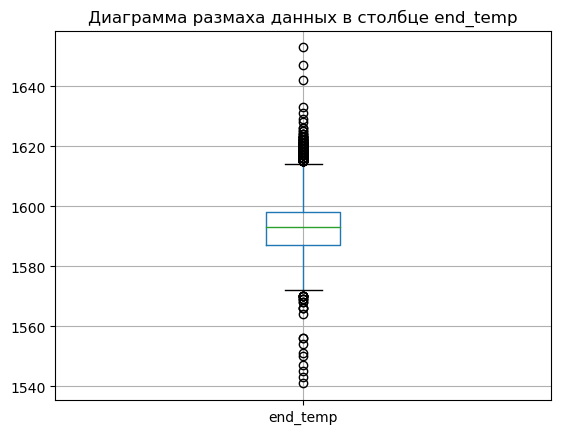

wire_1


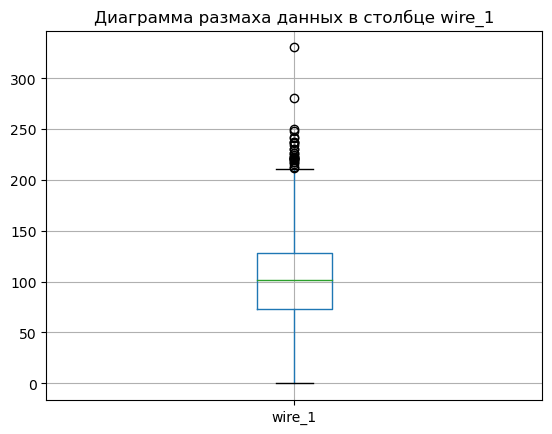

wire_2


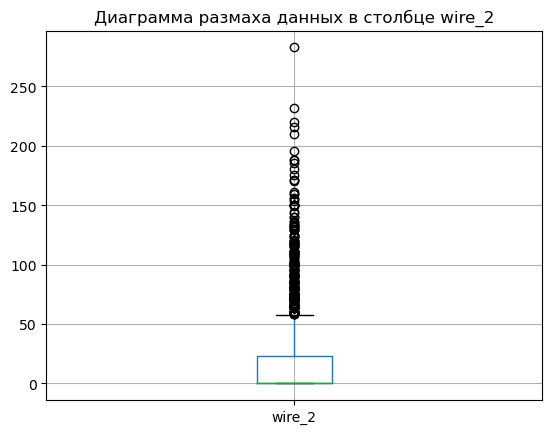

wire_3


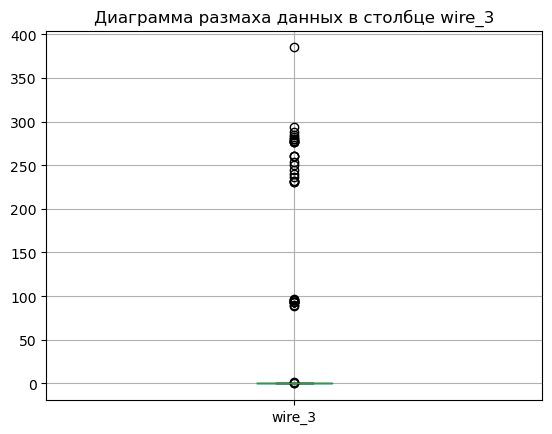

wire_4


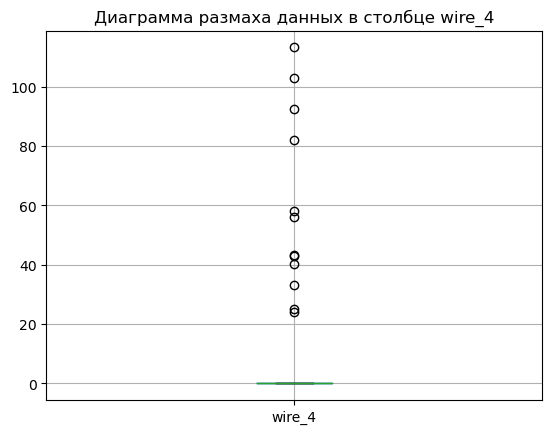

wire_5


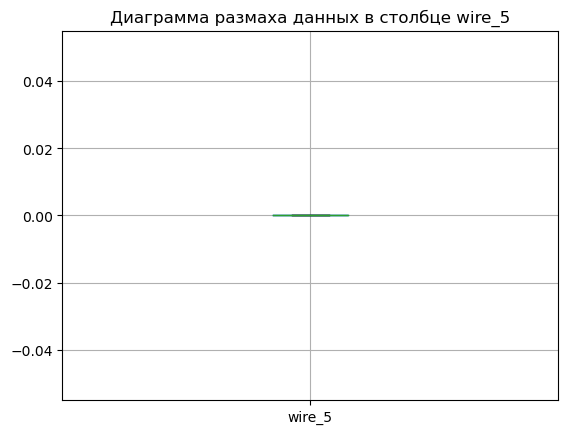

wire_6


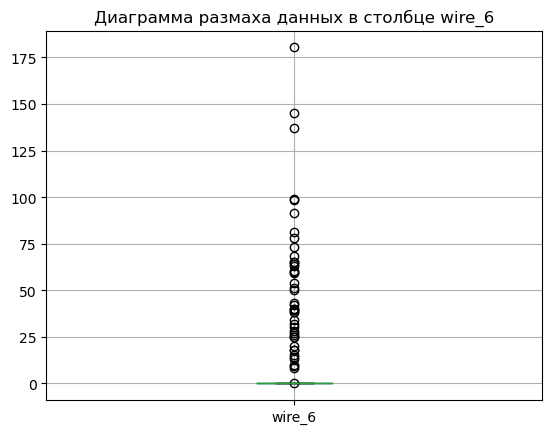

wire_7


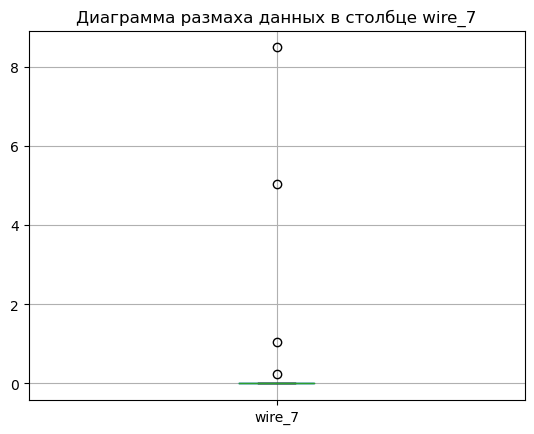

wire_8


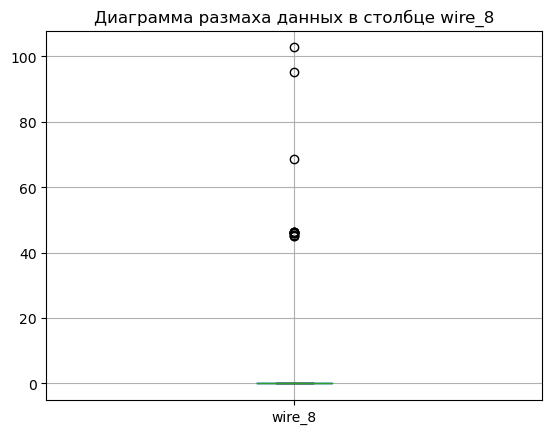

wire_9


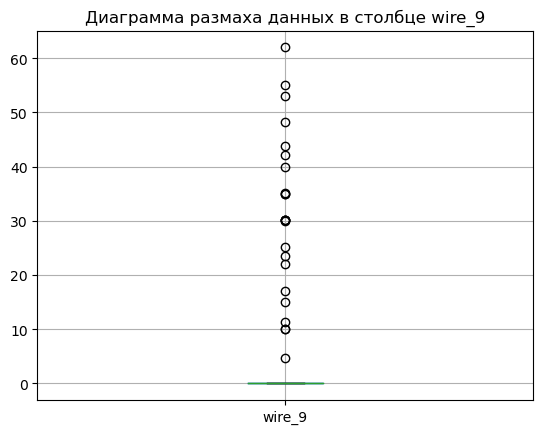

In [70]:
for column in data_full.columns:
    print(column)
    data_full.boxplot(column=column)
    plt.title('Диаграмма размаха данных в столбце '+column)
    plt.show()

Теперь проверим данные на корреляцию.

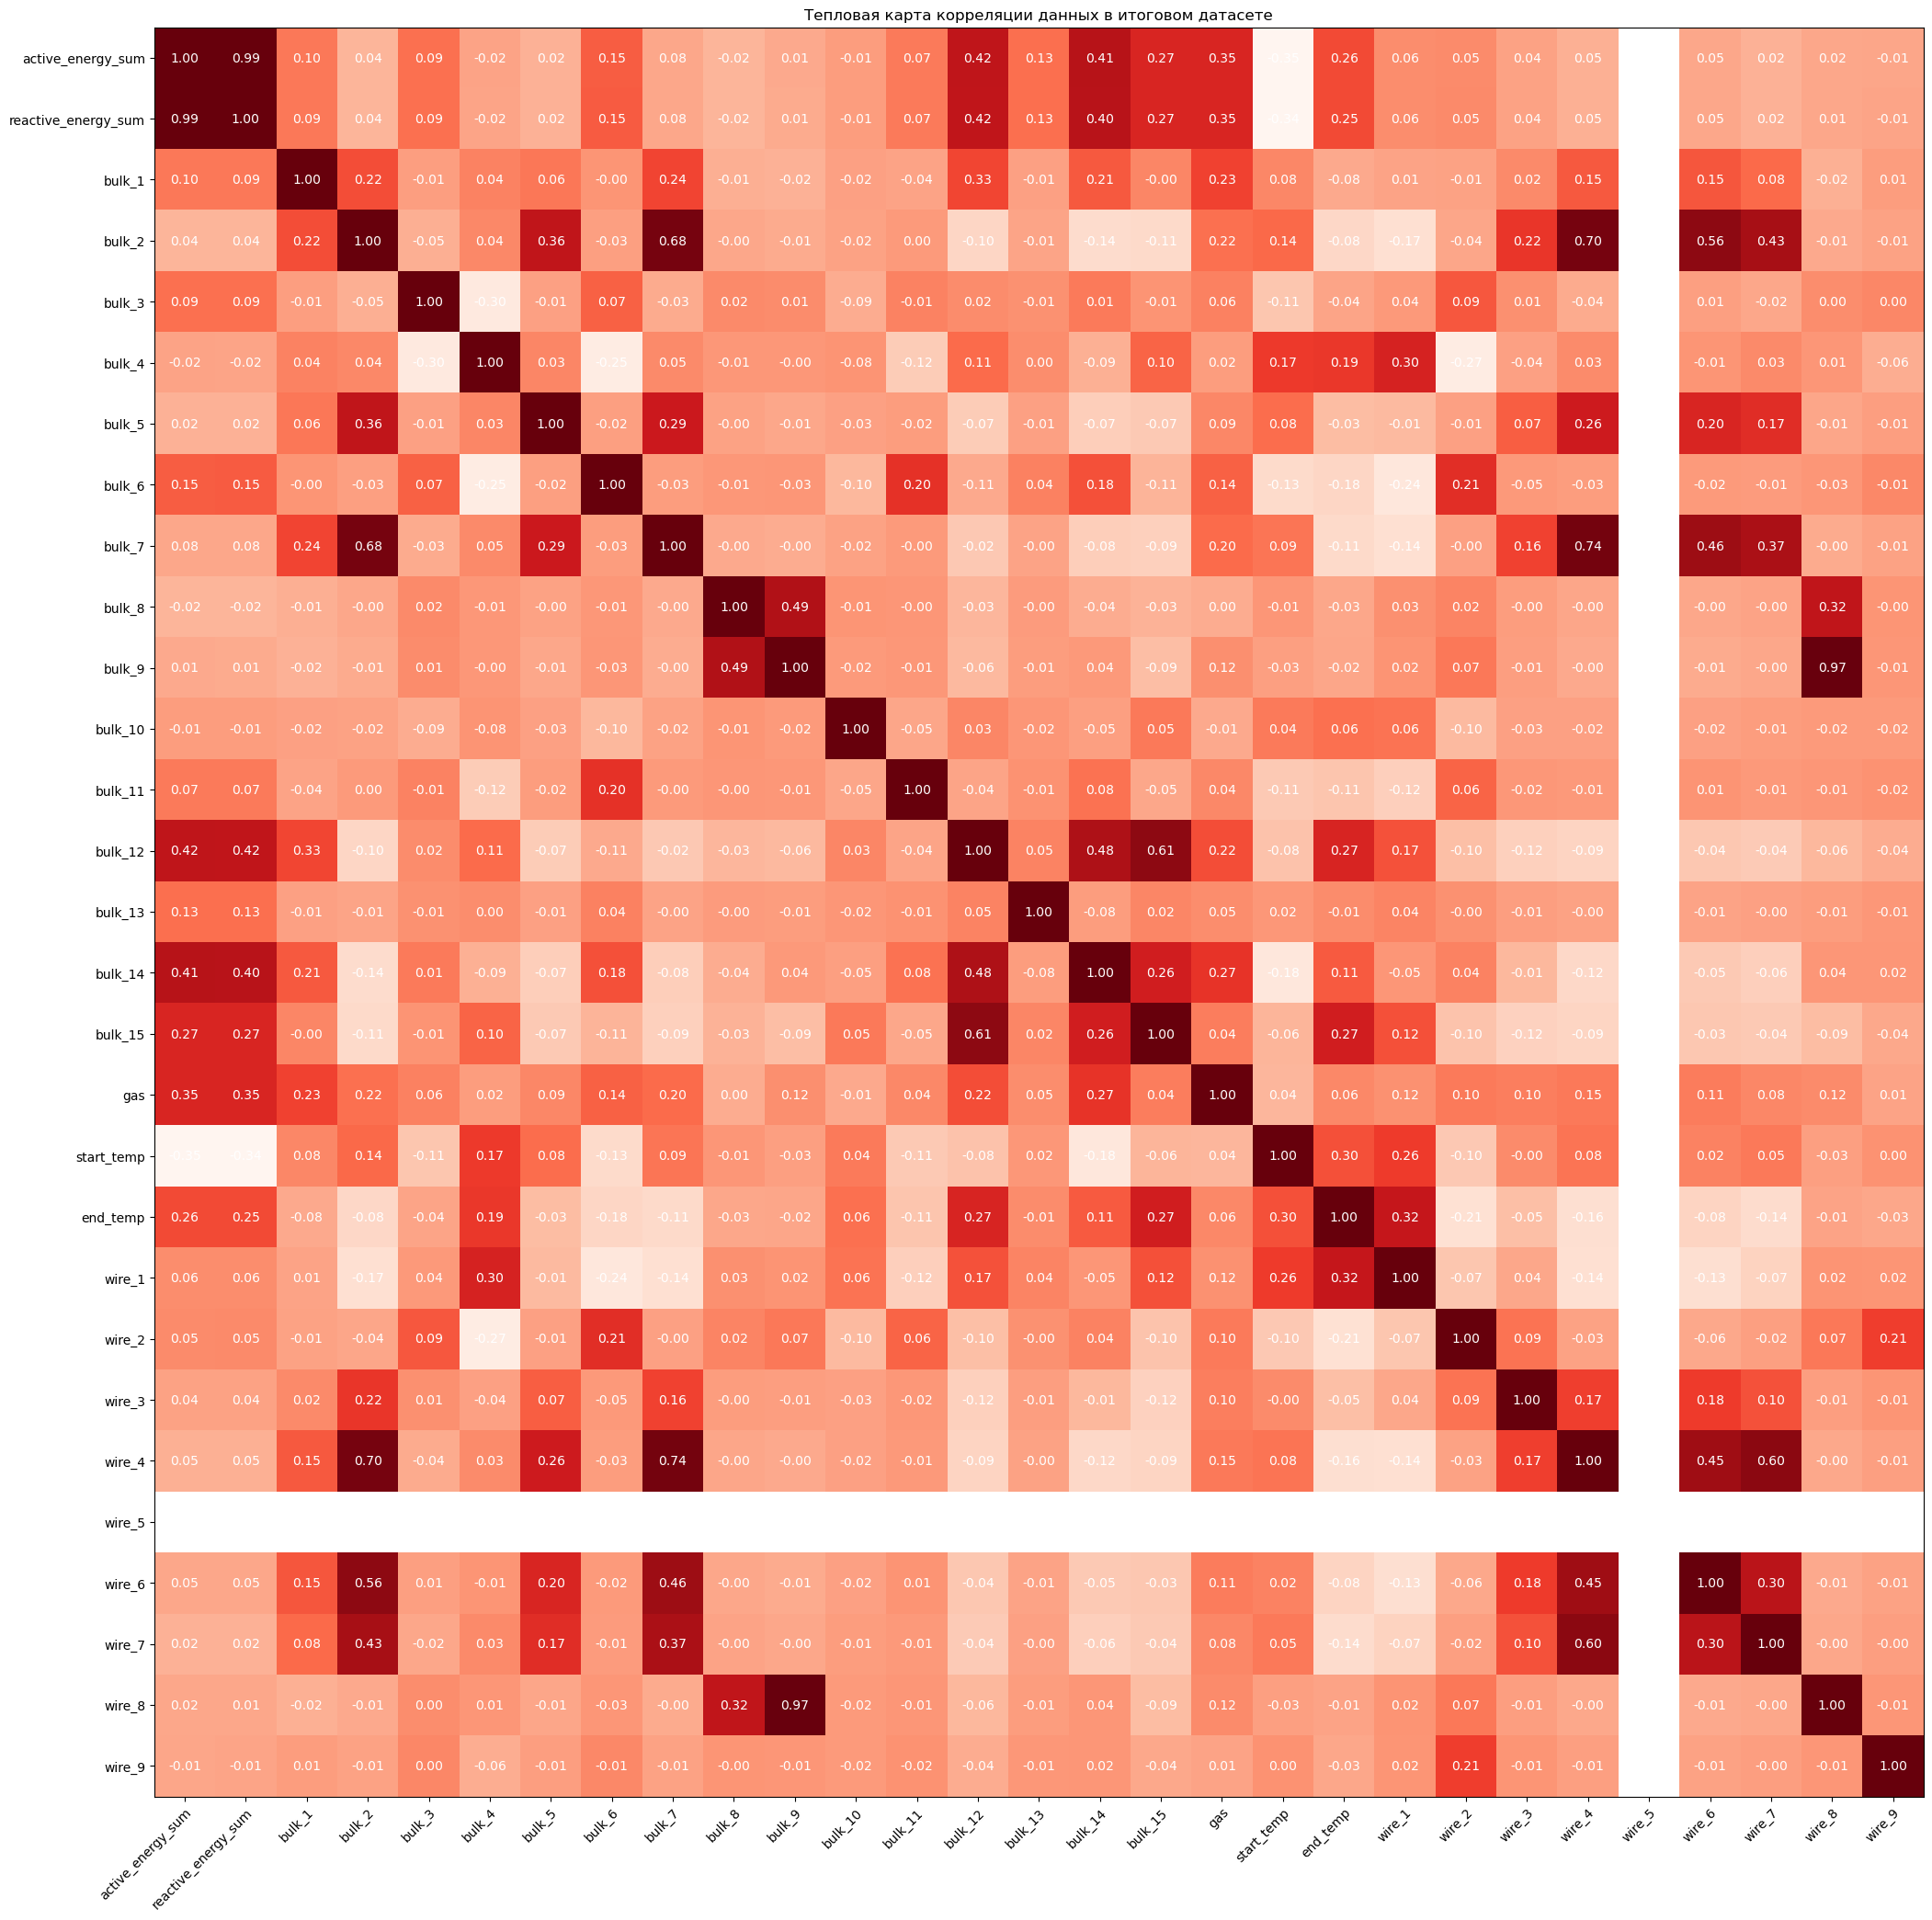

In [71]:
heatmap_data = data_full.corr()
fig, ax = plt.subplots(figsize=(25, 25))
ax.set_xticks(np.arange(len(heatmap_data.index)))
ax.set_yticks(np.arange(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.index)
ax.set_yticklabels(heatmap_data.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.title('Тепловая карта корреляции данных в итоговом датасете')
data = heatmap_data.values
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.index)):
        text = ax.text(j, i, '{:.2f}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(heatmap_data.corr(), cmap='Reds')

Из хитмэпа видно, что очень сильно коррелируют между собой столбцы reactive_energy_sum и active_energy_sum - удалим один из них. Также очень сильная корреляция между bulk_9 и wire_8, удалим столбец bulk_9. Кроме того, видно, что в столбце wire_5 просто нет значений - удалим его тоже.

In [72]:
data_full = data_full.drop(['active_energy_sum', 'bulk_9', 'wire_5'], axis=1)

Теперь посмотрим, какие столбцы влияют на таргет.

In [73]:
data_full.corr()['end_temp']

reactive_energy_sum    0.251472
bulk_1                -0.075428
bulk_2                -0.082543
bulk_3                -0.037156
bulk_4                 0.187817
bulk_5                -0.028446
bulk_6                -0.180906
bulk_7                -0.107371
bulk_8                -0.026613
bulk_10                0.061227
bulk_11               -0.114936
bulk_12                0.266805
bulk_13               -0.010974
bulk_14                0.114893
bulk_15                0.265772
gas                    0.059079
start_temp             0.301882
end_temp               1.000000
wire_1                 0.317488
wire_2                -0.207242
wire_3                -0.047636
wire_4                -0.159839
wire_6                -0.084149
wire_7                -0.137349
wire_8                -0.010818
wire_9                -0.027561
Name: end_temp, dtype: float64

Для модели KNN будем рассматривать только те столбцы, корреляция в которых больше 0.1 (это нужно для поиска аномалий)

In [74]:
data_full.corr()['end_temp'].abs() >= 0.1

reactive_energy_sum     True
bulk_1                 False
bulk_2                 False
bulk_3                 False
bulk_4                  True
bulk_5                 False
bulk_6                  True
bulk_7                  True
bulk_8                 False
bulk_10                False
bulk_11                 True
bulk_12                 True
bulk_13                False
bulk_14                 True
bulk_15                 True
gas                    False
start_temp              True
end_temp                True
wire_1                  True
wire_2                  True
wire_3                 False
wire_4                  True
wire_6                 False
wire_7                  True
wire_8                 False
wire_9                 False
Name: end_temp, dtype: bool

In [75]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   reactive_energy_sum  2324 non-null   int64  
 1   bulk_1               2324 non-null   float64
 2   bulk_2               2324 non-null   float64
 3   bulk_3               2324 non-null   float64
 4   bulk_4               2324 non-null   float64
 5   bulk_5               2324 non-null   float64
 6   bulk_6               2324 non-null   float64
 7   bulk_7               2324 non-null   float64
 8   bulk_8               2324 non-null   float64
 9   bulk_10              2324 non-null   float64
 10  bulk_11              2324 non-null   float64
 11  bulk_12              2324 non-null   float64
 12  bulk_13              2324 non-null   float64
 13  bulk_14              2324 non-null   float64
 14  bulk_15              2324 non-null   float64
 15  gas                  2324 non-null   f

In [76]:
data_full.head()

,reactive_energy_sum,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_10,...,start_temp,end_temp,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,444489437000,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,274689995000,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,428038924000,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,...,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,413941976999,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,...,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,303070918000,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,...,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


### Выводы по части 2

На этом этапе мы уже провели предобработку данных, удалив или заполнив пропуски и избавившись от очевидных выбросов.
Кроме того, был изменен тип данных в строках со временем.
Датасет готов. Можно переходить к обучению модели.

## Обучение модели

Мы будем пробовать обучить 4 модели: LinearRegression, RandomForest, CatBoostRegressor и LGBMRegressor

### Подготовка признаков

In [77]:
RANDOM_STATE = 80523
data_train, data_test = train_test_split(data_full, test_size=0.25, random_state=RANDOM_STATE)

In [78]:
model = KNN()
data_train_anomaly = data_train[['reactive_energy_sum', 'bulk_4','bulk_6', 'bulk_7', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15',\
                               'start_temp', 'end_temp','wire_1', 'wire_2', 'wire_4', 'wire_7']]
model.fit(data_train_anomaly)
data_train_anomaly['outlier'] = model.predict(data_train_anomaly) == 1
outliers = data_train_anomaly['outlier'].sum()
outlier_indexes = list(data_train_anomaly[data_train_anomaly['outlier'] == 1].index)
good_indexes = list(set(data_train_anomaly.index) - set(outlier_indexes))

data_train = data_train.drop(outlier_indexes)

In [79]:
features_train = data_train.drop('end_temp', axis=1)
target_train = data_train['end_temp']
features_test = data_test.drop('end_temp', axis=1)
target_test = data_test['end_temp']

### LinearRegression

In [80]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(features_train)
features_train_lin = scaler.transform(features_train)
features_test_lin = scaler.transform(features_test)

In [81]:
%%time

model_reg = LinearRegression()

print(f'''Значение метрики MAE на обучающей выборке для LinearRegression''', 
      cross_val_score(model_reg, features_train_lin, target_train, 
                         cv = 5, 
                         n_jobs = -1, 
                         scoring = 'neg_mean_absolute_error').mean()*(-1))

Значение метрики MAE на обучающей выборке для LinearRegression 6.608861451995464
Wall time: 4.21 s


### Случайный лес

In [82]:
%%time

model_forest = RandomForestRegressor(random_state=RANDOM_STATE)
params_forest = [{'criterion':['mse'],
                'n_estimators':[x for x in range(50, 501, 50)]}]
grid_forest = GridSearchCV(model_forest, params_forest, scoring='neg_mean_absolute_error', cv=5)
grid_forest.fit(features_train, target_train)
display(grid_forest.best_score_*(-1))
display(grid_forest.best_params_)

6.429786424755031

{'criterion': 'mse', 'n_estimators': 400}

Wall time: 1min 49s


### CatBoostRegressor

In [83]:
%%time

model_cat = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)
parameters_cat = {'learning_rate':[x/100 for x in range(1, 3)]}
grid_cat = GridSearchCV(model_cat, parameters_cat, cv=5, scoring='neg_mean_absolute_error')
grid_cat.fit(features_train, target_train)
display(grid_cat.best_score_*(-1))
display(grid_cat.best_params_)

6.382343787722287

{'learning_rate': 0.01}

Wall time: 24.6 s


### LGBMRegressor

In [84]:
%%time

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
params_lgbm = [{'num_leaves':[x for x in range(20,31)], 
                'learning_rate':[x/100 for x in range(3, 6)]}]
grid_lgbm = GridSearchCV(model_lgbm, params_lgbm, cv=5, scoring='neg_mean_absolute_error')
grid_lgbm.fit(features_train, target_train)
display(grid_lgbm.best_score_*(-1))
display(grid_lgbm.best_params_)

6.3786663018894085

{'learning_rate': 0.04, 'num_leaves': 28}

Wall time: 15.2 s


### Выводы по части 3

Лучшая модель на тренировочной выборке - LGBMRegressor с learning_rate=0.04 и num_leaves=28.

## Тестирование лучшей модели

In [85]:
model_fin = grid_lgbm.best_estimator_
pred = model_fin.predict(features_test)
print(mean_absolute_error(pred, target_test))

6.696859731359821


Модель показывает достаточно низкую для нашей задачи метрику MAE.

### Исследование важности признаков

In [86]:
model_fin.feature_importances_

array([419,  47,   0,  74,  88,   3, 116,   0,   0,   4,  47, 170,   0,
       259, 175, 370, 431, 337, 158,   2,   0,   0,   0,   0,   0])

In [87]:
feature_imp = pd.DataFrame({'Value': model_fin.feature_importances_, 'Feature': features_test.columns})
feature_imp

,Value,Feature
0,419,reactive_energy_sum
1,47,bulk_1
2,0,bulk_2
3,74,bulk_3
4,88,bulk_4
5,3,bulk_5
6,116,bulk_6
7,0,bulk_7
8,0,bulk_8
9,4,bulk_10


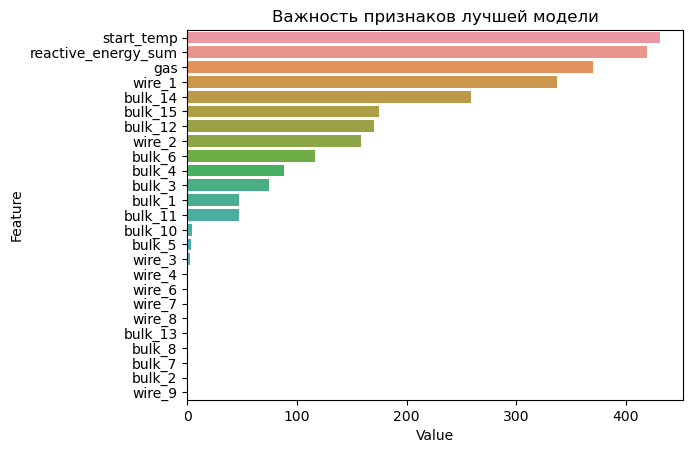

In [88]:
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False))
plt.title('Важность признаков лучшей модели')
plt.show()

Видно, что наиболее важные признаки - суммарная энергия и стартовая температура, также довольно важна информация о газе. Из сыпучих материалов наибольшей важностью обладает 14 колонка, из проволочных - первая.

### Сравнение с константной моделью

In [89]:
med = median(target_train)
med

1592.0

In [90]:
pred_const = np.array([med]*target_test.shape[0])

In [91]:
mean_absolute_error(pred_const, target_test)

8.044750430292599

Видно, что константная медианная модель предсказывает хуже нашей - значит, наша проходит проверку на адекватность.

### Выводы по части 4

Лучшая модель - LGBMRegressor с learning_rate=0.04 и num_leaves=28 - показывает результат 6.7 по метрике MAE.
Наиболее важные признаки - суммарная энергия и стартовая температура, также довольно важны данные о продувке сплава газом, первая колонка данных о проволочных материалах и 14 колонка данных о сыпучих материалах.
Можно заметить, что довольно много признаков вообще не играют никакой роли.

Модель проходит проверку на адекватность - предсказывает лучше, чем константная медианная модель (у нее MAE=8.04).

## Отчет об исследовании

### Сравнение плана и решения

Изначальный план работы включал в себя следующие пункты:
- Исследовательский анализ данных (изучение информации о таблицах, графический анализ)
- Предобработка данных (удаление аномалий, заполнение пропусков, где возможно)
- агрегация данных в один датафрейм для обучения модели, создание тренировочной и тестовой выборок
- Сравнительный анализ нескольких моделей на тренировочной выборке (LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor)
- Тестирование лучшей модели на тестовой выборке
- Отчет

Все пункты плана были выполнены, без отклонений. Сначала данные были исследованы, потом обработаны, собраны в один датафрейм и разбиты на обучающую и тестовую выборку в пропорции 1:3. После этого были обучены 4 модели, выбрана лучшая и протестирована на тестовой выборке.

### Описание трудностей

Первая трудность, с которой я столкнулся - при объединении всех данных в один датафрейм нельзя было просто поставить их рядом, поскольку там может быть разное число строк, не все ключи встречаются в каждой таблице. Эту проблемы удалось решить объединением таблиц по ключу медотом inner join.
Вторая и основная трудность - большие временные затраты на обучение моделей. В финальной версии эта проблема была решена путем уменьшения количества гиперпараметров, которые мы перебираем.

### Описание ключевых шагов решения

#### Подготовка данных

На этом этапе было сделано следующее:
- названия столбцов во всех датафреймах приведены к общему виду формата camelcase
- данные о времени приведены к формату datetime
- удалены аномальные значения мощности и температуры
- подготовлен новый признак - энергия (произведение мощности на время)
- удалены партии, где замеров температуры не было или был только один
- подготовлены признак "температура первого нагрева" и целевой признак "температура после последнего нагрева"
- данные объединены в один датафрейм по ключу "номер партии"

#### Обучение моделей

Были обучены 4 модели: LinearRegression, RandomForest, CatBoostRegressor и LGBMRegressor.
Для последних трех был проведен автоматический подбор гиперпараметров с помощью GridSearchCV.
Параметры, которы перебирались для RandomForest:
- количество деревьев от 50 до 500 с шагом 50, лучший результат - 400
Параметры, которые перебирались для CatBoostRegressor:
- learning rate от 0.1 до 0.3 с шагом 0.1, лучший результат - 0.1
Параметры, которые перебирались для LGBMRegressor:
- learning rate от 0.3 до 0.6 с шагом 0.1, лучший результат - 0.4
- количество листьев от 20 до 30, лучший результат - 28

По итогам была выбрана лучшая модель - LGBMRegressor с learning_rate=0.04 и num_leaves=28. На тренировочной выборке она показала метрику MAE=6.38. После этого эта модель была протестирована на тестовой выборке, где показала мтерику MAE=6.7, чего достаточно по условиям задачи (MAE < 6.8). 
Потом была выполнена проверка важности признаков. Наиболее важные признаки - суммарная энергия и стартовая температура, также довольно важны данные о продувке сплава газом, первая колонка данных о проволочных материалах и 14 колонка данных о сыпучих материалах.
Довольно много признаков вообще не играют никакой роли.
И, наконец, модель была проверена на адекватность путем сравнения с константной медианной моделью.
Модель проходит проверку на адекватность - предсказывает лучше, чем константная медианная модель (у нее MAE=8.04).

### Признаки, использованные для обучения модели

В итоговом датафрейме, использованном для обучения, оказались следующие данные:
- данные о проволочных материалах (кроме 5 столбца, где не было ни одной записи)
- данные о сыпучих материалах (кроме 9 столбца, который был выкинут из-за сильной корреляции с другой колонкой)
- данные о продувке сплава газом
- начальная температура
- реактивная суммарная энергия (активная суммарная энергия очень коррелирует с ней, поэтому была выкинута)

### Полное описание модели

Лучшей моделью для этой задачи оказалась модель LGBMRegressor с learning_rate=0.04 и num_leaves=28. Также при обучении модели был использован параметр random_state=80523.

### Итоговая метрика

На тестовой выборке лучшая модель получила MAE=6.7.

### Рекомендации по улучшению решения

В дальнейшем в этой задаче можно попробовать следующее:
- рассмотреть какие-нибудь другие модели
- увеличить число переьираемых гиперпараметров, чтобы лучше подгонять модель под задачу.